# 3) Statistical Analysis of Depth Erros Due To Bandlimited Seismic

*Chris Field, April 2022*

**Function:**

* Statistical analysis of depth errors
    * Table
    * Historgrams

* Semivariograms
    * Table
    * Pictures
    * 4x4 Depth Error Picture
    * 4x4 Depth Error Kirchhoff & RTMIG

* Madograms
    * Table
    * Pictures
    * 4x4 Depth Error Picture
    * 4x4 Depth Error Kirchhoff & RTMIG

**Required Inputs:**
Artifical interfaces and seismic interpretation of the interfaces in csv nDI format TBZ (event) ascii.

In [1]:
import os  # operating system
import sys # to add src directory for my modules
#
from pprint import pprint
#
import math
import random
#
import numpy as np
import pandas as pd
#
from scipy import stats
from scipy import signal
from scipy.interpolate import interp1d
#
# Plotting requirements
import matplotlib.pyplot as plt
import matplotlib.font_manager # different fonts
from matplotlib import rcParams # runtime config to set fonts


In [2]:
# Using rcParams set the global fonts for Matplotlib
# Global parameters for Matplotlib: set font etc.
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']
rcParams['font.serif'] = ['Garamond']
rcParams['font.size'] = '16'
#

## Define functions

In [3]:
def plot_depth_error_histogram(df, tvdss_diff='TVDSS_DIFF', 
                             title = 'Histogram', file_out=False, f_base_name='Histogram', fsize=14, location='./'):
    '''
    Function to create histogram of depth errors
    Requires SciPy stats
    Inputs:
        df - dataframe with mistie data
        tvdss_diff - dataframe column name for the depth delta
        title - text string
        file_out - export figure, Boolean
        f_base_name - base of the file name for the figures
        fsize - font size
        location - Figs will be saved here

    Outputs: 
        Optionally saves png to disk and plots graph'''
    #Take the data for the specific top and calcualte some statistics:

    mistie_data=df[[tvdss_diff]].values

    av = np.round(np.average(mistie_data),1)
    mean = np.round(np.mean(mistie_data),1)
    std = np.round(np.std(mistie_data),1)
    
    # Set up plot
    fig = plt.figure(figsize=(12,8)) 
    ax = fig.add_subplot(1,1,1)

    # calculate other parameters needed to plot Gaussian
    ## Plot between min and max x axis with .001 steps
    abs_min = np.abs(np.min(mistie_data))
    abs_max = np.abs(np.max(mistie_data))
    xrange = max(abs_min, abs_max)
    x_axis = np.arange(-1*xrange, xrange, 0.01)

    # plot the depth error histogram
    # Generate histogram plot, we require maximum count to normalise the Gaussian
    y, x, _ = ax.hist(mistie_data, bins='auto', color = '#ED1D24', alpha=0.6, rwidth=0.6)
    y_max = y.max()

    # plot Gaussian curve centered at 0
    ax.plot(x_axis, (y_max*std*2.51)*stats.norm.pdf(x_axis, loc=0, scale=std), color='grey', alpha=0.4)
    
    # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    ax.tick_params(
        bottom=False,
        left=False, 
    )

    ## Add bar lines as a horizontal grid.
    ax.yaxis.grid(color='white')

    # Axis labels and title
    ax.set_xlabel('Actual minus seismic, m',fontsize=fsize)
    ax.set_ylabel('Frequency',fontsize=fsize)
    ax.set_title(title, fontsize=fsize)
    #
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    xlrange=xlim[1]-xlim[0];
    ylrange=ylim[1]-ylim[0];
    ax.text(xlim[0]+0.001*xlrange, ylim[1]-0.025*ylrange, f'''
    The average error is {mean}m and the standard deviation is {std}m.''', fontsize=fsize, alpha=0.3)
    
    plt.tight_layout()
    
    # Show and save the graph
    plt.show()
    if file_out:
        fig_name=location + f_base_name + '_Histogram_'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)
    
    return

In [4]:
def plot_depth_error_histogram_set_x(df, tvdss_diff='TVDSS_DIFF', xlim=25,
                             title = 'Histogram', file_out=False, f_base_name='Histogram', fsize=14, location='./'):
    '''
    Function to create histogram of depth errors
    Requires SciPy stats
    Inputs:
        df - dataframe with mistie data
        tvdss_diff - dataframe column name for the depth delta
        xlim - negative and positive limits of x axis
        title - text string
        file_out - export figure, Boolean
        f_base_name - base of the file name for the figures
        fsize - font size
        location - Figs will be saved here

    Outputs: 
        Optionally saves png to disk and plots graph'''
    #Take the data for the specific top and calcualte some statistics:

    mistie_data=df[[tvdss_diff]].values

    av = np.round(np.average(mistie_data),1)
    mean = np.round(np.mean(mistie_data),1)
    std = np.round(np.std(mistie_data),1)
    
    # Set up plot
    fig = plt.figure(figsize=(12,8)) 
    ax = fig.add_subplot(1,1,1)
    
    # Set xlimits of plot
    ax.set_xlim(-1*xlim, xlim, auto=False)
    
    # calculate other parameters needed to plot Gaussian
    ## Plot between min and max x axis with .001 steps
    x_axis = np.arange(-1*xlim, xlim, 0.01)

    # plot the depth error histogram
    # Generate histogram plot, we require maximum count to normalise the Gaussian
    y, x, _ = ax.hist(mistie_data, bins='auto', color = '#ED1D24', alpha=0.6, rwidth=0.6)
    y_max = y.max()

    # plot Gaussian curve centered at 0
    ax.plot(x_axis, (y_max*std*2.51)*stats.norm.pdf(x_axis, loc=0, scale=std), color='grey', alpha=0.4)
    
    # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## Remove tick marks.
    ax.tick_params(
        bottom=False,
        left=False, 
    )

    ## Add bar lines as a horizontal grid.
    ax.yaxis.grid(color='white')

    # Axis labels and title
    ax.set_xlabel('Actual minus seismic, m',fontsize=fsize)
    ax.set_ylabel('Frequency',fontsize=fsize)
    ax.set_title(title, fontsize=fsize)
    #
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    xlrange=xlim[1]-xlim[0];
    ylrange=ylim[1]-ylim[0];
    ax.text(xlim[0]+0.001*xlrange, ylim[1]-0.025*ylrange, f'''
    The average error is {mean}m and the standard deviation is {std}m.''', fontsize=fsize, alpha=0.3)
    
    plt.tight_layout()
    
    # Show and save the graph
    plt.show()
    if file_out:
        fig_name=location + f_base_name + '_Histogram_setx'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)
    
    return

In [5]:
def semivariance(samples):
    """
    Return the semivariance of a timeseries, as defined in Turcotte 1997
    Input:
    samples -- the timeseries, a list or NumPy array of numbers
    """
    length = len(samples)
    gamma = []
    
    for k in range(length-1):
        # Do the summation over values separated by k
        sumk = 0
        for i in range(length-k):
            diff = int(samples[i+k]) - int(samples[i])
            sumk += (diff) ** 2

        gamma_k = (1/(2*(length-k)))*sumk
        # Add this to our gamma list
        gamma.append(gamma_k)
        
    return gamma

In [6]:
def restrict_quarter(gamma):
    """
    Restrict list or array (typically semivariance) to the first quarter (rounded up):
    "it is common practice to restrict the range to 1/4 of the length of that data" Gallant et al. 1994
    
    Return the semivariance of a timeseries, as defined in Turcotte 1997
    
    Input:
    gamma -- the (semivariance) timeseries, a list or NumPy array of numbers
    
    Output:
    gamma_trunc -- truncated (semivariance) timeseries, a list or NumPy array of numbers
    """
    length = len(gamma)
    new_length = math.ceil(length/4)
    gamma_trunc = gamma[:new_length]
        
    return gamma_trunc

In [7]:
def gamma_plot(gamma, start=1, title='Semivariogram', step = 1, file_out=False, location='./Plot/'):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- intended to be the semivariance, a list
    start -- start from lag start, int
    """
    gamm_trun = gamma[start:]
    x_init = np.arange(len(gamm_trun)) 
    x = x_init * step
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Separation (m)')
    ax.set_ylabel('Semivariance')
    
    ax.plot(x, gamm_trun, alpha =0.6, color='#1f77b4', solid_capstyle="butt", lw=3)

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.tight_layout()
    
    plt.show()
    
    if file_out:
        fig_name=location + title.replace(" ", "_") + '_semivariogram'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)

In [8]:
def gamma_plot_log(gamma, start=1, title='Semivariogram', step=1):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- intended to be the semivariance, a list
    start -- start from lag start, int
    """
    gamm_trun = gamma[start:]
    x_init = np.arange(len(gamm_trun)) 
    x = x_init * step
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Log(Separation)')
    ax.set_ylabel('Log(Semivariance)')
    
    ax.plot(np.log10(x), np.log10(gamm_trun), alpha =0.6, color='#1f77b4', solid_capstyle="butt", lw=3)

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.tight_layout()
    
    plt.show()

In [9]:
def gamma_log_slope_intercept(gamma, start=0, title='Semivariogram', step=1, s_der_strt=1, s_der_fin=-1):
    """
    Return intercept and gradient of variogram regression in log-log space.
    
    gamma -- intended to be the semivariance, a list
    start -- start from lag start, int
    title -- title, string
    label_slope -- put the regression slope on the ploy or not, bool
    step -- spatial step size (m),
    s_der_start -- start of regression derivation in log log space (in number of grid points separation)
    s_der_fin -- end of regression derivation in log log space (in number of grid points separation from the end, neg number)
    """
    gamm_trun = gamma[start:]
    x_init = np.arange(len(gamm_trun)) 
    x = x_init * step
    
    print(f'For {title}:\n')
    
        # Do a regression and work out the slope
    res = stats.linregress(np.log10(x[s_der_strt:s_der_fin]), np.log10(gamm_trun[s_der_strt:s_der_fin]))
    
    res_slope = res.slope
    res_int = res.intercept
    haus = res_slope/2
    frac_dim = 2 - haus
    
    res_slope = round(res_slope, 2)
    res_int = round(res_int, 2)
    haus = round(haus, 2)
    frac_dim =round(frac_dim, 2)
    
    print(f'The slope is {res_slope} and intercept it {res_int}. The Hausdorff measure is {haus}, and the fractal dimension is {frac_dim}.')
    print()
    print('################################################')
    # plot

    return res.slope, res.intercept, x, gamm_trun

In [10]:
def gamma_plot_log_slope(gamma, start=1, title='Semivariogram', label_slope=True, step=1, s_der_strt=1, s_der_fin=-1, file_out=False, location='./Plot/'):
    """
    Plot a list or array, e.g. variogram, in log-log space with derived linear regression
    To just use the first two points for the regressions_der_strt=1, s_der_fin=3
        
    gamma -- intended to be the semivariance, a list
    start -- start from lag start, int
    title -- title, string
    label_slope -- put the regression slope on the ploy or not, bool
    step -- spatial step size (m),
    s_der_start -- start of regression derivation in log log space (in number of grid points separation)
                    Note this is from point 1 or parger as 0 (which is no separation) gives -inf,
    s_der_fin -- end of regression derivation in log log space (number of grid points separation from the end as a neg number, or positive counting onwards from the start)
    """
    slope , intercept, x, gamm_trun = gamma_log_slope_intercept(gamma=gamma, start=start, title=title, step=step, s_der_strt=s_der_strt, s_der_fin=s_der_fin)
    
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Log(Separation)')
    ax.set_ylabel('Log(Semivariance)')
    
    ax.plot(np.log10(x), np.log10(gamm_trun), alpha =0.6, color='#1f77b4', marker='o')
    
        
    label = 'Slope = ' + str(round(slope,2))
    # Bold version over derive area
    ax.plot(np.log10(x[s_der_strt:s_der_fin]), intercept + slope*np.log10(x[s_der_strt:s_der_fin]),  alpha=0.9, color='grey', 
            linewidth=5)
    # Thinner over the rest of the plot
    ax.plot(np.log10(x[1:-1]), intercept + slope*np.log10(x[1:-1]),  alpha=0.8, color='grey', 
        linewidth=2)

    if label_slope:
        ax.text(3, 3.5 , label, color='grey')

        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    plt.tight_layout()
    
    plt.show()

    if file_out:
        fig_name=location + title.replace(" ", "_") + '_semivariogram_loglog'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)
        
    return

In [11]:
def combined_gamma_plot2(df_plot, depth_col='Z', title='Title', step=2, s_der_strt=1, s_der_fin=3, file_out=False, location='./Plot/'):
    """
    Plot the semivariogram and log-log plot of semivariogram with derived slope.
    Input:
    df_plot -- input dataframe
    depth_col -- column of dataframe with interface depth values
    title -- title at top of plot (string)
    step -- step of each point laterally in metres
    remove_end -- how much of the end of the log-log plot to remove when deriving slope
    """
    samples = df_plot[depth_col].to_list()
    gamma = semivariance(samples)
    gamma_trunc = restrict_quarter(gamma)
    gamma_plot(gamma_trunc, title=title, start=0, step =step, file_out=file_out, location=location)
    print(f'the length of the truncated semivariance is {len(gamma_trunc)}')
    gamma_plot_log_slope(gamma_trunc, title=title, start=0, step =step, s_der_strt=s_der_strt, s_der_fin=s_der_fin, file_out=file_out, location=location )

In [12]:
def gamma_list_plot_log(gammas, labels, start=1, title='Semivariograms', step=1, file_out=False, location='./Plot/'):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- list of semivariance functions, up to 3 items
    labels -- labels of semivariance functions
    start -- start from lag start, int
    """
    colours = ['#1f77b4', '#ED1D24', '#1CEDAB']
    
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Log(Separation)')
    ax.set_ylabel('Log(Semivariance)')
    
    num_gammas = len(gammas)
    
    for i in range(num_gammas):
        colour = colours[i]
        gamma = gammas[i]
        label = labels[i]
        gamm_trun = gamma[start:]
        x_init = np.arange(len(gamm_trun)) 
        x = x_init * step
        ax.plot(np.log10(x[1:]), np.log10(gamm_trun[1:]), alpha =0.6, color=colour, solid_capstyle="butt", lw=3, label=label)

    ax.legend(loc='best')
        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
    
    plt.show()
    
    
    if file_out:
        fig_name=location + title.replace(" ", "_") + label.replace(" ", "_").replace(".", "_").replace(",", "_") + '_semivariograms_loglog'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)

In [13]:
def gamma_list_plot(gammas, labels, start=1, title='Semivariograms', step=1, file_out=False, location='./Plot/'):
    """
    Plot a list or array, e.g. variogram
    
    gamma -- list of semivariance functions, up to 3 items
    labels -- labels of semivariance functions
    start -- start from lag start, int
    """
    colours = ['#1f77b4', '#ED1D24', '#1CEDAB']
    
    # plot
    fig = plt.figure(figsize=(14,7)) 
    ax = fig.add_subplot(1,1,1)

    ax.set_title(title)
    
    ax.set_xlabel('Separation (m)')
    ax.set_ylabel('Semivariance')
    
    num_gammas = len(gammas)
    
    for i in range(num_gammas):
        colour = colours[i]
        gamma = gammas[i]
        label = labels[i]
        gamm_trun = gamma[start:]
        x_init = np.arange(len(gamm_trun)) 
        x = x_init * step
        ax.plot(x, gamm_trun, alpha =0.6, color=colour, solid_capstyle="butt", lw=3, label=label)

    ax.legend(loc='best')
        # cosmetics
    ## Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
    
    plt.show()
    
    
    if file_out:
        fig_name=location + title.replace(" ", "_") + label.replace(" ", "_").replace(".", "_").replace(",", "_") + '_semivariograms'  +'.png'
        fig.savefig(fig_name,facecolor = 'w',bbox_inches="tight",dpi=1000)

# Input and output spectral slope methods

In [14]:
location_in = './Input_3/'

location_out='./Output_3/'
location_out_plots='./Pictures/Horizon_analysis_plots/'

# If necessary make output folders
if not os.path.exists(location_out) :
    os.makedirs(location_out)
    
if not os.path.exists(location_out_plots) :
    os.makedirs(location_out_plots)

In [15]:
# List files in input directory:
files_in = os.listdir(location_in)
pprint(files_in)

['220314_ZOMBIE_nDI_XYZ_csv.dat.csv',
 'ZOMBIE_35deg_std_and_horizon_metrics_handmade.xlsx']


In [16]:
# Read csv nDI format TBZ (event) ascii
df_input=pd.read_csv(location_in + '220314_ZOMBIE_nDI_XYZ_csv.dat.csv')
# Remove quote marks from column names
df_input.columns=df_input.columns.str.replace('\"','')
# Some column names have trailing white space, remove this
df_input.columns=df_input.columns.str.replace('\s+','')

In [17]:
df_input.head()

,X,Y,Spectral_slope_interface_1p92,Spectral_slope_interface_1p89,Pareto_fault_interface_b_2p0,Pareto_fault_interface_b_1p5,sin1000,const2000,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35,Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35,Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20,Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35,Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20,Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35,Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20,const2000SPIRIT:T0_20,const2000SPIRIT:T0_35,"sin1000SPIRIT:T0_35,1","sin1000SPIRIT:T0_20,1"
0,0.0,0.0,2008.0,1885.0,2000.0,2000.0,2000.0,2000.0,2000.7715,1999.9526,2000.3784,1981.7206,1997.1846,1998.0609,1890.1084,1890.6650,1992.7896,1993.1111,2002.4084,2002.7471
1,2.0,0.0,1998.0,1886.0,2002.0,2002.0,2001.0,2000.0,2001.5028,2000.4363,2000.8640,2003.0907,1997.7722,1998.5756,1891.2126,1891.6086,1993.0562,1993.2693,2003.3043,2003.4910
2,4.0,0.0,2001.0,1895.0,2004.0,2004.0,2003.0,2000.0,2002.4099,2001.0135,2001.4531,2003.3712,1998.3762,1999.0978,1892.2097,1892.5613,1993.2136,1993.4314,2004.1200,2004.2373
3,6.0,0.0,1999.0,1899.0,2006.0,2006.0,2004.0,2000.0,2003.1957,2001.9067,2002.0142,2003.4294,1999.0138,1999.4857,1893.3008,1893.5382,1993.3726,1993.5714,2004.0000,2005.0667
4,8.0,0.0,2004.0,1895.0,2006.0,2004.0,2005.0,2000.0,2003.7676,2002.7202,2002.5195,2003.5330,1999.4595,1999.8708,1894.3058,1894.4984,1993.5253,1993.7346,2005.9272,2005.9219


In [18]:
# Remove column Y (all zeros) and first and last 1.5km (7750 rows)
df_input.drop(['Y'], axis=1, inplace=True)

In [19]:
df_input = df_input.iloc[750:-750]

Create snapped - original event differences

In [20]:
# Constant interface:
df_input['const_20_MIN_ORIG'] = df_input['const2000SPIRIT:T0_20'] - df_input['const2000']
df_input['const_35_MIN_ORIG'] = df_input['const2000SPIRIT:T0_35'] - df_input['const2000']

# Sine interface:
df_input['sin_20_MIN_ORIG'] = df_input['sin1000SPIRIT:T0_20,1'] - df_input['sin1000']
df_input['sin_35_MIN_ORIG'] = df_input['sin1000SPIRIT:T0_35,1'] - df_input['sin1000']

# Pareto faulting
df_input['Pareto_fault_b_2p0_20_MIN_ORIG'] = df_input['Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20'] - df_input['Pareto_fault_interface_b_2p0']
df_input['Pareto_fault_b_2p0_35_MIN_ORIG'] = df_input['Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35'] - df_input['Pareto_fault_interface_b_2p0']
df_input['Pareto_fault_b_1p5_20_MIN_ORIG'] = df_input['Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20'] - df_input['Pareto_fault_interface_b_1p5']
df_input['Pareto_fault_b_1p5_35_MIN_ORIG'] = df_input['Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35'] - df_input['Pareto_fault_interface_b_1p5']

# Spectral slope
df_input['Spectral_slope_1p89_20_MIN_ORIG'] = df_input['Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20'] - df_input['Spectral_slope_interface_1p89']
df_input['Spectral_slope_1p89_35_MIN_ORIG'] = df_input['Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35'] - df_input['Spectral_slope_interface_1p89']
df_input['Spectral_slope_1p92_20_MIN_ORIG'] = df_input['Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20'] - df_input['Spectral_slope_interface_1p92']
df_input['Spectral_slope_1p92_35_MIN_ORIG'] = df_input['Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35'] - df_input['Spectral_slope_interface_1p92']


## Statistical Analysis

In [21]:
desc = df_input.describe()

In [22]:
desc

,X,Spectral_slope_interface_1p92,Spectral_slope_interface_1p89,Pareto_fault_interface_b_2p0,Pareto_fault_interface_b_1p5,sin1000,const2000,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35,Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35,...,sin_20_MIN_ORIG,sin_35_MIN_ORIG,Pareto_fault_b_2p0_20_MIN_ORIG,Pareto_fault_b_2p0_35_MIN_ORIG,Pareto_fault_b_1p5_20_MIN_ORIG,Pareto_fault_b_1p5_35_MIN_ORIG,Spectral_slope_1p89_20_MIN_ORIG,Spectral_slope_1p89_35_MIN_ORIG,Spectral_slope_1p92_20_MIN_ORIG,Spectral_slope_1p92_35_MIN_ORIG
count,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.0,3501.000000,3501.000000,3501.000000,...,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000
mean,5000.000000,1998.520708,2022.353328,2040.246787,1329.872322,2000.000000,2000.0,2039.853426,2039.637406,1328.812127,...,-0.805849,-0.854518,-0.393361,-0.609381,-0.709819,-1.060195,0.414409,-0.062333,0.529996,-0.022954
std,2021.591947,45.416264,35.534032,125.856422,185.496677,70.721821,0.0,125.974814,126.003824,185.536785,...,0.603912,0.590122,2.152135,2.101643,2.680507,2.283853,5.589284,5.397981,5.627564,5.335204
min,1500.000000,1910.000000,1945.000000,1855.000000,1102.000000,1900.000000,2000.0,1855.177000,1855.165500,1099.921600,...,-2.304300,-2.444500,-5.953600,-6.191700,-6.786900,-7.411600,-16.157200,-15.939500,-13.848100,-14.721400
25%,3250.000000,1963.000000,1992.000000,1935.000000,1198.000000,1930.000000,2000.0,1934.803600,1934.313700,1197.322300,...,-1.245400,-1.282800,-1.689000,-1.886000,-2.641400,-2.796600,-3.368900,-3.601100,-3.180200,-3.487800
50%,5000.000000,1989.000000,2023.000000,1989.000000,1250.000000,2000.000000,2000.0,1989.153800,1988.326400,1249.180900,...,-0.835900,-0.897200,-0.587200,-0.755100,-0.947000,-1.208500,-0.293000,-0.632100,-0.208700,-0.530800
75%,6750.000000,2037.000000,2047.000000,2173.000000,1452.000000,2070.000000,2000.0,2172.539300,2171.987100,1449.234600,...,-0.319500,-0.419900,0.582500,0.417000,0.716200,0.498000,3.210200,2.616600,3.401200,2.693100
max,8500.000000,2105.000000,2136.000000,2313.000000,1733.000000,2100.000000,2000.0,2313.120100,2312.562500,1728.926500,...,0.601900,0.612300,18.465300,18.762000,18.657200,7.393300,23.663100,25.205700,25.905500,25.333300


In [23]:
desc.to_excel(location_out+'ZOMBIE_stats.xlsx')

In [24]:
df_zero_mean_diff = df_input[['const_20_MIN_ORIG', 'const_35_MIN_ORIG','sin_20_MIN_ORIG','sin_35_MIN_ORIG','Pareto_fault_b_2p0_20_MIN_ORIG','Pareto_fault_b_2p0_35_MIN_ORIG','Pareto_fault_b_1p5_20_MIN_ORIG','Pareto_fault_b_1p5_35_MIN_ORIG','Spectral_slope_1p89_20_MIN_ORIG','Spectral_slope_1p89_35_MIN_ORIG','Spectral_slope_1p92_20_MIN_ORIG','Spectral_slope_1p92_35_MIN_ORIG'
]].copy(deep=True)

In [25]:
df_zero_mean_diff = df_zero_mean_diff - df_zero_mean_diff.mean()

In [26]:
df_zero_mean_diff.describe()

,const_20_MIN_ORIG,const_35_MIN_ORIG,sin_20_MIN_ORIG,sin_35_MIN_ORIG,Pareto_fault_b_2p0_20_MIN_ORIG,Pareto_fault_b_2p0_35_MIN_ORIG,Pareto_fault_b_1p5_20_MIN_ORIG,Pareto_fault_b_1p5_35_MIN_ORIG,Spectral_slope_1p89_20_MIN_ORIG,Spectral_slope_1p89_35_MIN_ORIG,Spectral_slope_1p92_20_MIN_ORIG,Spectral_slope_1p92_35_MIN_ORIG
count,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03,3.501000e+03
mean,-3.231665e-15,-6.195901e-14,-9.600369e-16,2.165268e-16,-2.222285e-15,2.079139e-15,-1.673865e-15,1.314129e-15,1.220643e-15,2.351605e-15,-2.891083e-15,3.403289e-15
std,1.737092e-01,1.102135e-01,6.039121e-01,5.901223e-01,2.152135e+00,2.101643e+00,2.680507e+00,2.283853e+00,5.589284e+00,5.397981e+00,5.627564e+00,5.335204e+00
min,-8.533104e-01,-5.418128e-01,-1.498451e+00,-1.589982e+00,-5.560239e+00,-5.582319e+00,-6.077081e+00,-6.351405e+00,-1.657161e+01,-1.587717e+01,-1.437810e+01,-1.469845e+01
25%,3.468957e-02,1.948723e-02,-4.395509e-01,-4.282817e-01,-1.295639e+00,-1.276619e+00,-1.931581e+00,-1.736405e+00,-3.783309e+00,-3.538767e+00,-3.710196e+00,-3.464846e+00
50%,3.468957e-02,2.318723e-02,-3.005087e-02,-4.268172e-02,-1.938389e-01,-1.457192e-01,-2.371807e-01,-1.483047e-01,-7.074092e-01,-5.697668e-01,-7.386957e-01,-5.078458e-01
75%,3.868957e-02,2.318723e-02,4.863491e-01,4.346183e-01,9.758611e-01,1.026381e+00,1.426019e+00,1.558195e+00,2.795791e+00,2.678933e+00,2.871204e+00,2.716054e+00
max,3.898957e-02,2.658723e-02,1.407749e+00,1.466818e+00,1.885866e+01,1.937138e+01,1.936702e+01,8.453495e+00,2.324869e+01,2.526803e+01,2.537550e+01,2.535625e+01


In [27]:
df_zero_mean_diff.describe().to_excel(location_out+'ZOMBIE_stats_zero_mean.xlsx')

In [28]:
desc

,X,Spectral_slope_interface_1p92,Spectral_slope_interface_1p89,Pareto_fault_interface_b_2p0,Pareto_fault_interface_b_1p5,sin1000,const2000,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20,Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35,Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35,...,sin_20_MIN_ORIG,sin_35_MIN_ORIG,Pareto_fault_b_2p0_20_MIN_ORIG,Pareto_fault_b_2p0_35_MIN_ORIG,Pareto_fault_b_1p5_20_MIN_ORIG,Pareto_fault_b_1p5_35_MIN_ORIG,Spectral_slope_1p89_20_MIN_ORIG,Spectral_slope_1p89_35_MIN_ORIG,Spectral_slope_1p92_20_MIN_ORIG,Spectral_slope_1p92_35_MIN_ORIG
count,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.0,3501.000000,3501.000000,3501.000000,...,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000,3501.000000
mean,5000.000000,1998.520708,2022.353328,2040.246787,1329.872322,2000.000000,2000.0,2039.853426,2039.637406,1328.812127,...,-0.805849,-0.854518,-0.393361,-0.609381,-0.709819,-1.060195,0.414409,-0.062333,0.529996,-0.022954
std,2021.591947,45.416264,35.534032,125.856422,185.496677,70.721821,0.0,125.974814,126.003824,185.536785,...,0.603912,0.590122,2.152135,2.101643,2.680507,2.283853,5.589284,5.397981,5.627564,5.335204
min,1500.000000,1910.000000,1945.000000,1855.000000,1102.000000,1900.000000,2000.0,1855.177000,1855.165500,1099.921600,...,-2.304300,-2.444500,-5.953600,-6.191700,-6.786900,-7.411600,-16.157200,-15.939500,-13.848100,-14.721400
25%,3250.000000,1963.000000,1992.000000,1935.000000,1198.000000,1930.000000,2000.0,1934.803600,1934.313700,1197.322300,...,-1.245400,-1.282800,-1.689000,-1.886000,-2.641400,-2.796600,-3.368900,-3.601100,-3.180200,-3.487800
50%,5000.000000,1989.000000,2023.000000,1989.000000,1250.000000,2000.000000,2000.0,1989.153800,1988.326400,1249.180900,...,-0.835900,-0.897200,-0.587200,-0.755100,-0.947000,-1.208500,-0.293000,-0.632100,-0.208700,-0.530800
75%,6750.000000,2037.000000,2047.000000,2173.000000,1452.000000,2070.000000,2000.0,2172.539300,2171.987100,1449.234600,...,-0.319500,-0.419900,0.582500,0.417000,0.716200,0.498000,3.210200,2.616600,3.401200,2.693100
max,8500.000000,2105.000000,2136.000000,2313.000000,1733.000000,2100.000000,2000.0,2313.120100,2312.562500,1728.926500,...,0.601900,0.612300,18.465300,18.762000,18.657200,7.393300,23.663100,25.205700,25.905500,25.333300


Dataframe for standard deviation plot

In [29]:
actual_list = [desc.loc['std']['Spectral_slope_interface_1p92'], desc.loc['std']['Spectral_slope_interface_1p89'], desc.loc['std']['Pareto_fault_interface_b_2p0'], desc.loc['std']['Pareto_fault_interface_b_1p5'], desc.loc['std']['sin1000'], desc.loc['std']['const2000']]

In [30]:
diff_list20 = [desc.loc['std']['Spectral_slope_1p92_20_MIN_ORIG'], desc.loc['std']['Spectral_slope_1p89_20_MIN_ORIG'], desc.loc['std']['Pareto_fault_b_2p0_20_MIN_ORIG'], desc.loc['std']['Pareto_fault_b_1p5_20_MIN_ORIG'], desc.loc['std']['sin_20_MIN_ORIG'], desc.loc['std']['const_20_MIN_ORIG']]

In [31]:
diff_list35 = [desc.loc['std']['Spectral_slope_1p92_35_MIN_ORIG'], desc.loc['std']['Spectral_slope_1p89_35_MIN_ORIG'], desc.loc['std']['Pareto_fault_b_2p0_35_MIN_ORIG'], desc.loc['std']['Pareto_fault_b_1p5_35_MIN_ORIG'], desc.loc['std']['sin_35_MIN_ORIG'], desc.loc['std']['const_35_MIN_ORIG']]

In [32]:
name_list = ['Spectral slope 1.92', 'Spectral slope 1.89', 'Pareto fault b 2.0', 'Pareto fault b 1.5', 'Sin', 'Const']

In [33]:
std_dict_20 = {'Name' : name_list, 'Actual Depth std' : actual_list, 'Seis - Actual std' : diff_list20 }

In [34]:
std_dict_35 = {'Name' : name_list, 'Actual Depth std' : actual_list, 'Seis - Actual std' : diff_list35 }

In [35]:
df20 = pd.DataFrame(std_dict_20)

In [36]:
df35 = pd.DataFrame(std_dict_35)

In [37]:
df20

,Name,Actual Depth std,Seis - Actual std
0,Spectral slope 1.92,45.416264,5.627564
1,Spectral slope 1.89,35.534032,5.589284
2,Pareto fault b 2.0,125.856422,2.152135
3,Pareto fault b 1.5,185.496677,2.680507
4,Sin,70.721821,0.603912
5,Const,0.000000,0.173709


In [38]:
df35

,Name,Actual Depth std,Seis - Actual std
0,Spectral slope 1.92,45.416264,5.335204
1,Spectral slope 1.89,35.534032,5.397981
2,Pareto fault b 2.0,125.856422,2.101643
3,Pareto fault b 1.5,185.496677,2.283853
4,Sin,70.721821,0.590122
5,Const,0.000000,0.110214


In [39]:
df20.to_excel(location_out+'ZOMBIE_20deg_std.xlsx')
df35.to_excel(location_out+'ZOMBIE_35deg_std.xlsx')

# Depth Error Plots

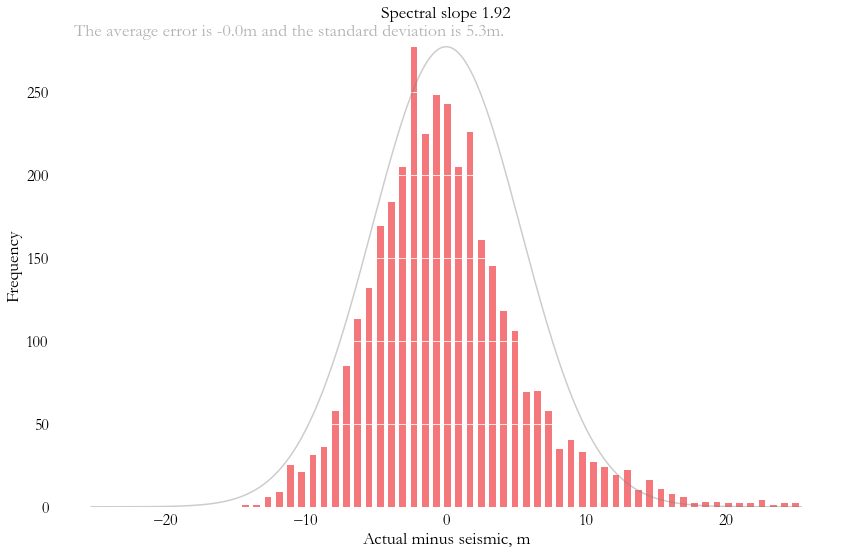

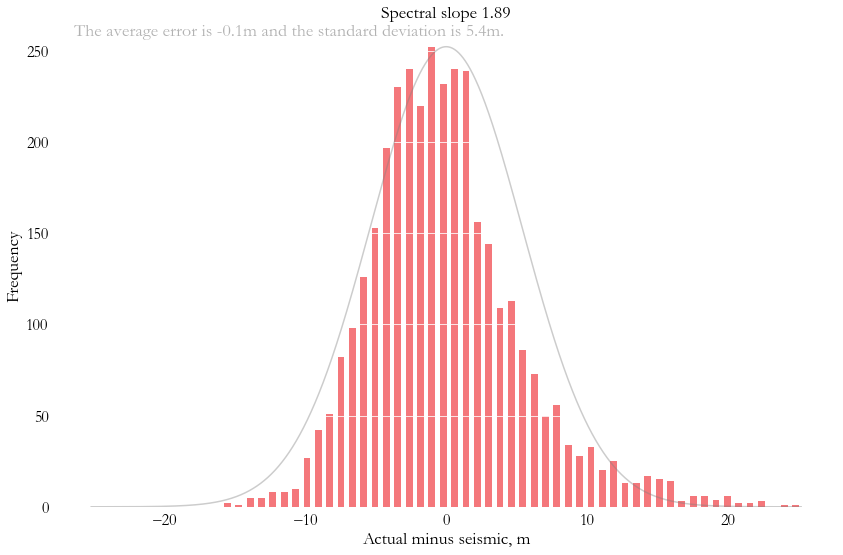

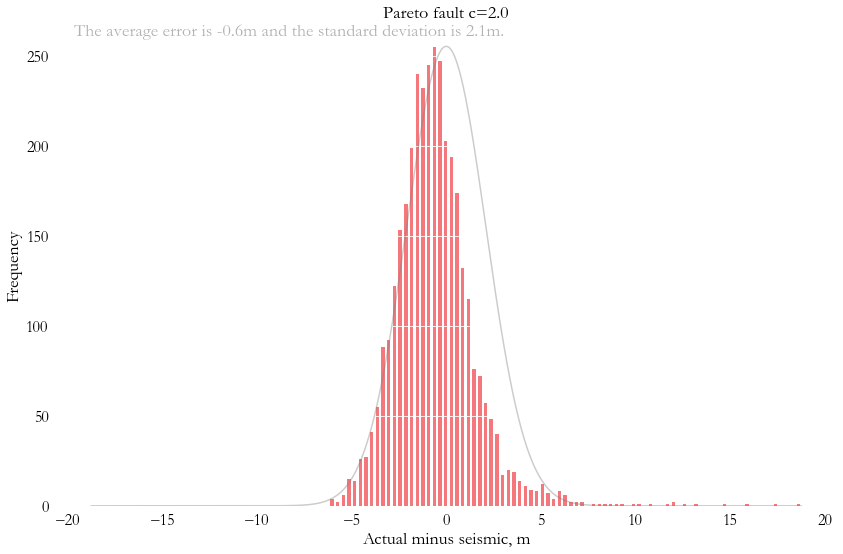

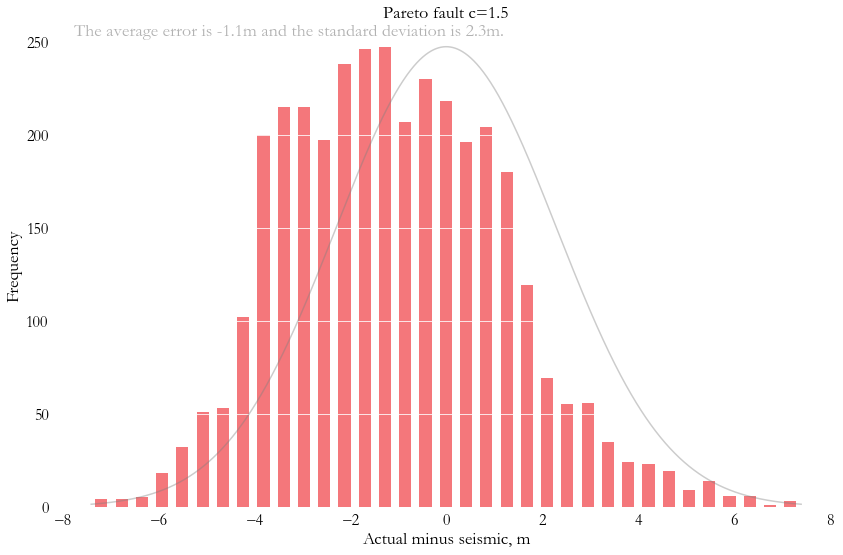

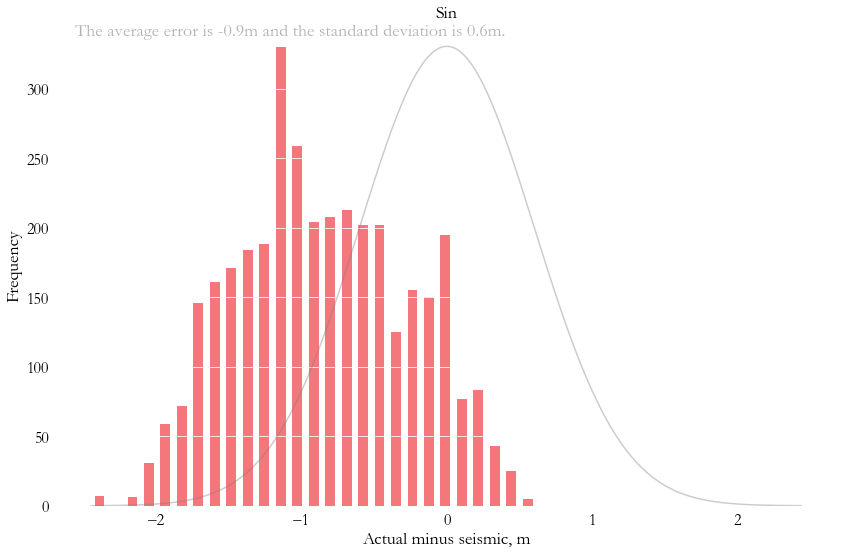

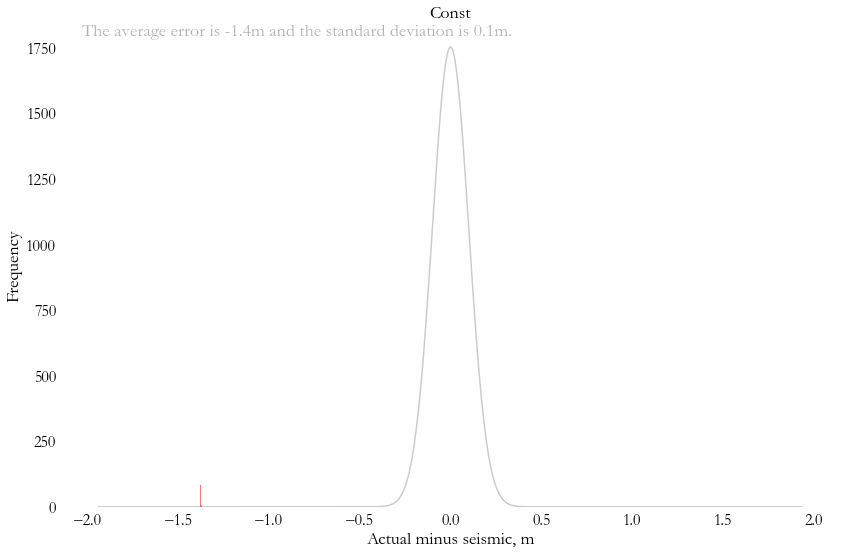

In [40]:
diff_list35 = ['Spectral_slope_1p92_35_MIN_ORIG', 'Spectral_slope_1p89_35_MIN_ORIG', 'Pareto_fault_b_2p0_35_MIN_ORIG', 'Pareto_fault_b_1p5_35_MIN_ORIG', 'sin_35_MIN_ORIG', 'const_35_MIN_ORIG']
name_list = ['Spectral slope 1.92', 'Spectral slope 1.89', 'Pareto fault c=2.0', 'Pareto fault c=1.5', 'Sin', 'Const']
for i in range(len(name_list)):
    plot_depth_error_histogram(df_input, tvdss_diff=diff_list35[i], 
                             title = name_list[i], file_out=True, f_base_name=diff_list35[i], fsize=18, location=location_out_plots)


## On same scale

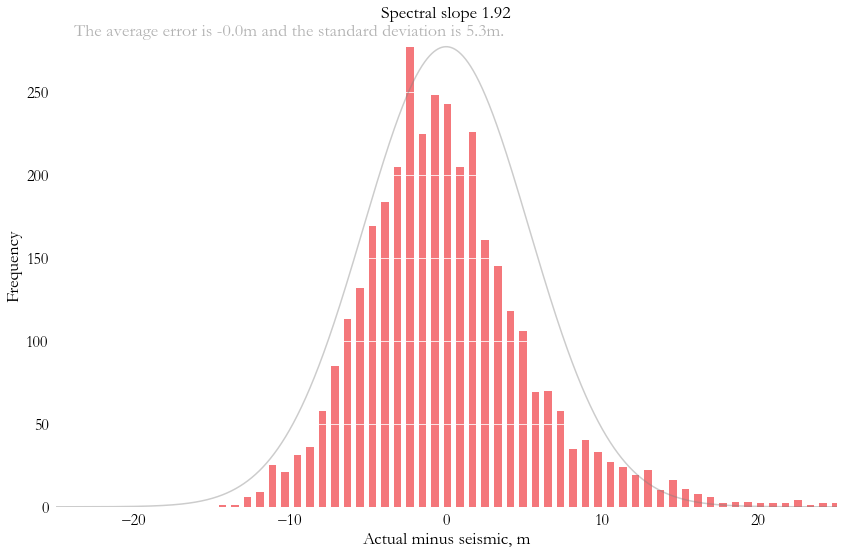

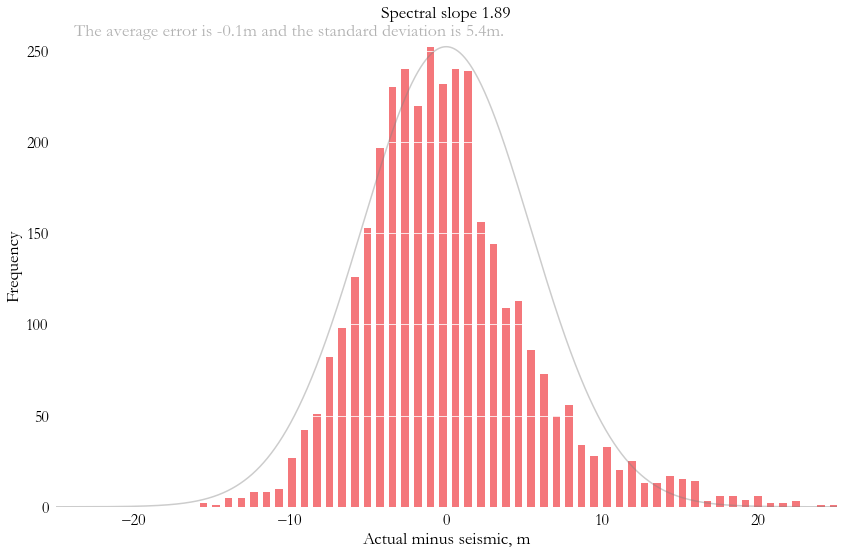

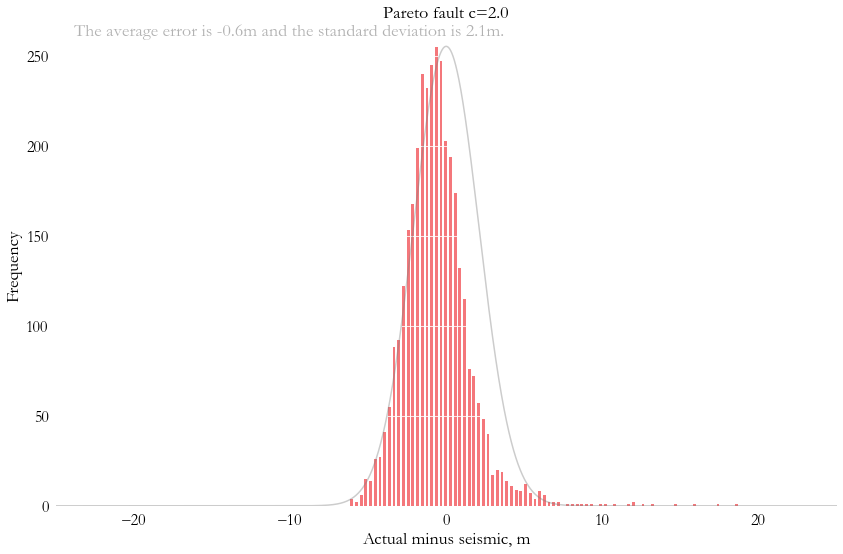

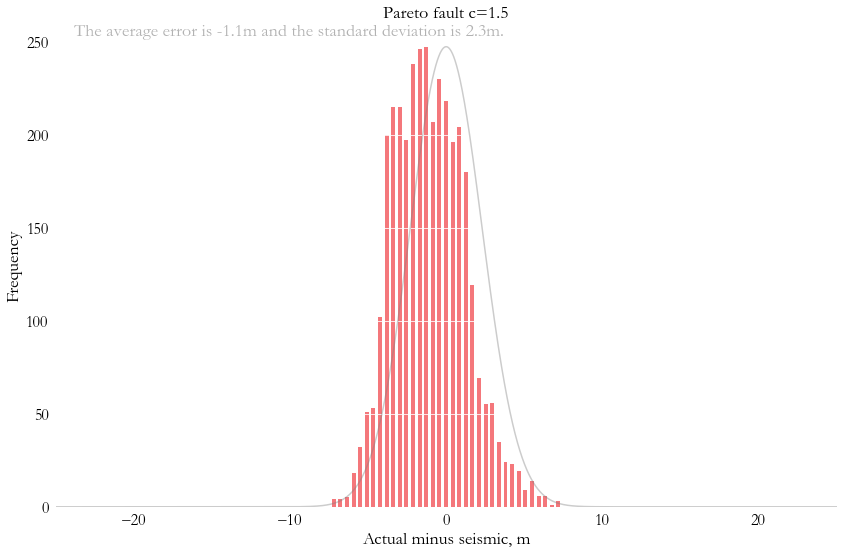

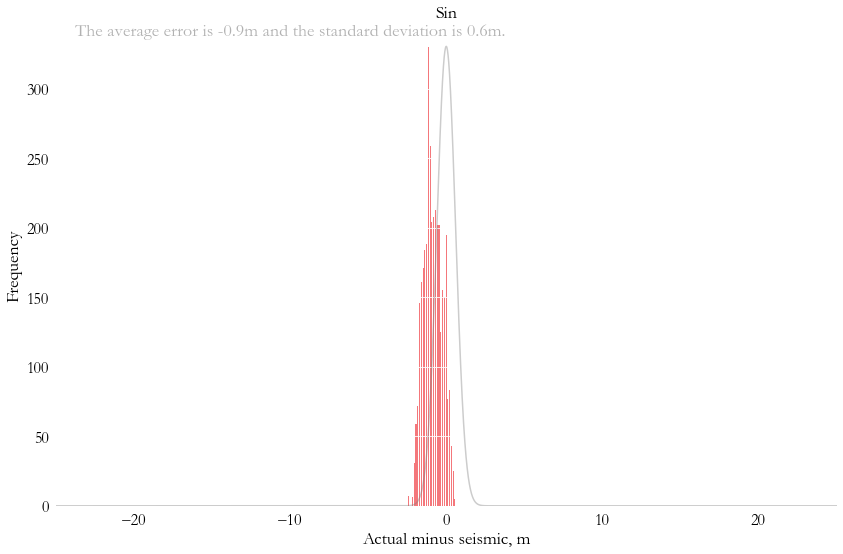

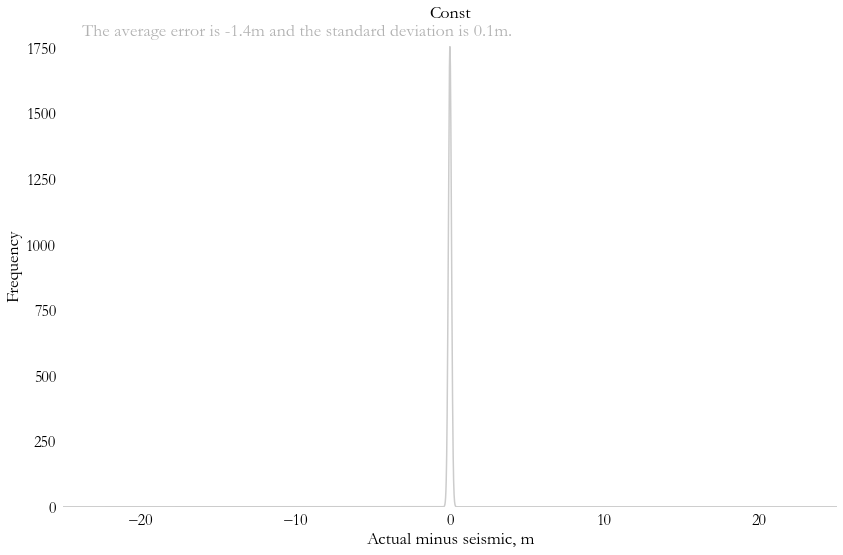

In [41]:
diff_list35 = ['Spectral_slope_1p92_35_MIN_ORIG', 'Spectral_slope_1p89_35_MIN_ORIG', 'Pareto_fault_b_2p0_35_MIN_ORIG', 'Pareto_fault_b_1p5_35_MIN_ORIG', 'sin_35_MIN_ORIG', 'const_35_MIN_ORIG']
name_list = ['Spectral slope 1.92', 'Spectral slope 1.89', 'Pareto fault c=2.0', 'Pareto fault c=1.5', 'Sin', 'Const']
for i in range(len(name_list)):
    plot_depth_error_histogram_set_x(df_input, tvdss_diff=diff_list35[i], xlim=25,
                             title = name_list[i], file_out=True, f_base_name=diff_list35[i], fsize=18, location=location_out_plots)


# Semivariogram

In [42]:
data_list = [
 ('Spectral_slope_interface_1p89','Spectral Slope 1.89'), ('Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35', 'Spectral Slope 1.89, Kirchhoff 35 deg mute'), 
 ('Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20', 'Spectral Slope 1.89, Kirchhoff 20 deg mute'), 
 ('Spectral_slope_interface_1p92', 'Spectral Slope 1.92'), ('Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35', 'Spectral Slope 1.92, Kirchhoff 35 deg mute'), 
 ('Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20', 'Spectral Slope 1.92, Kirchhoff 20 deg mute'), 
 ('Pareto_fault_interface_b_2p0', 'Pareto Faulted 2.0'), ('Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35', 'Pareto Faulted 2.0, Kirchhoff 35 deg mute'),
 ('Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20', 'Pareto Faulted 2.0, Kirchhoff 20 deg mute'),
 ('Pareto_fault_interface_b_1p5','Pareto Faulted 1.5'), ('Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35', 'Pareto Faulted 1.5, Kirchhoff 35 deg mute'),
 ('Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20', 'Pareto Faulted 1.5, Kirchhoff 20 deg mute'),
 ('sin1000', 'Sine, Wavelength 1000m'), ('sin1000SPIRIT:T0_35,1', 'Sine, Wavelength 1000m, Kirchhoff 35 deg mute'),
 ('sin1000SPIRIT:T0_20,1', 'Sine, Wavelength 1000m, Kirchhoff 20 deg mute')]

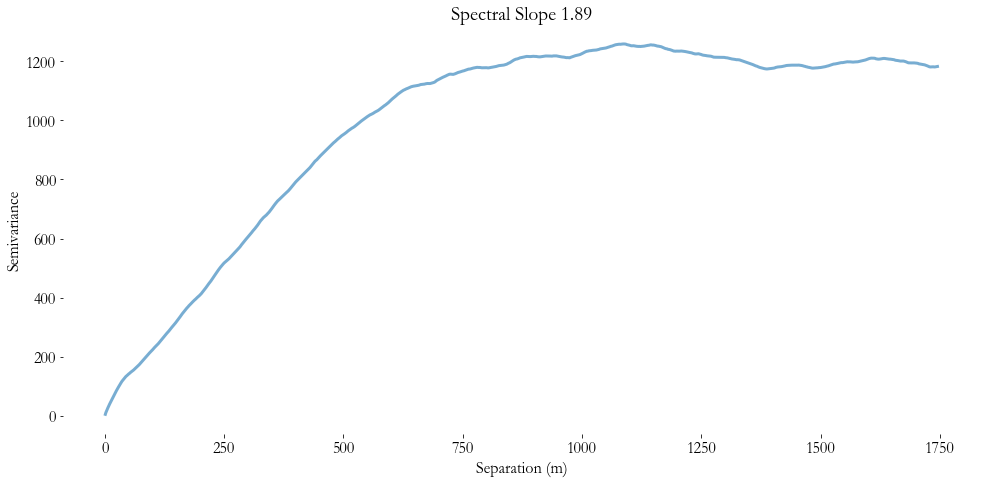

the length of the truncated semivariance is 875
For Spectral Slope 1.89:

The slope is 0.83 and intercept it 0.77. The Hausdorff measure is 0.41, and the fractal dimension is 1.59.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


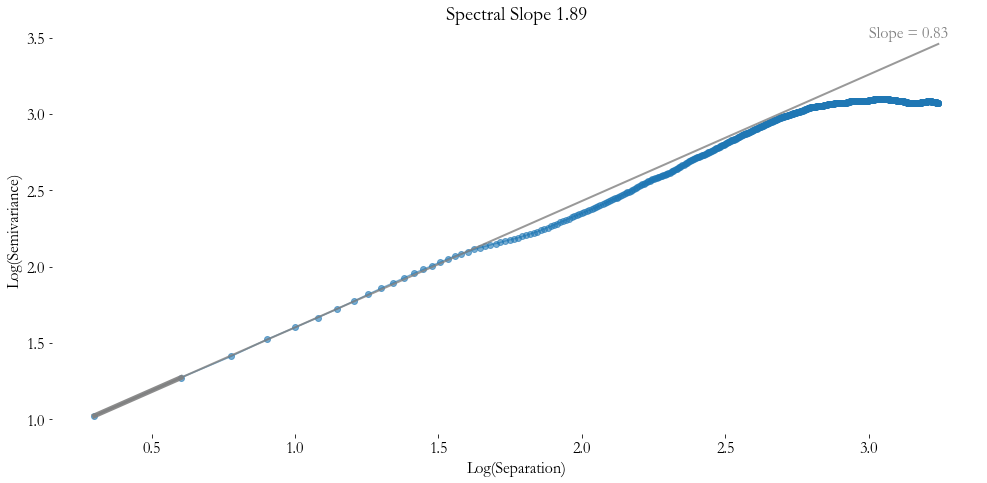

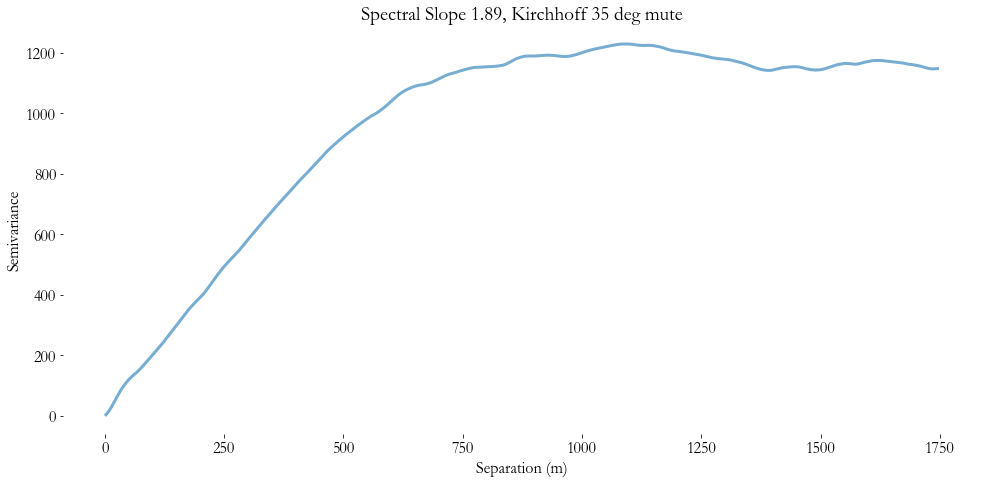

the length of the truncated semivariance is 875
For Spectral Slope 1.89, Kirchhoff 35 deg mute:

The slope is 1.12 and intercept it 0.14. The Hausdorff measure is 0.56, and the fractal dimension is 1.44.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


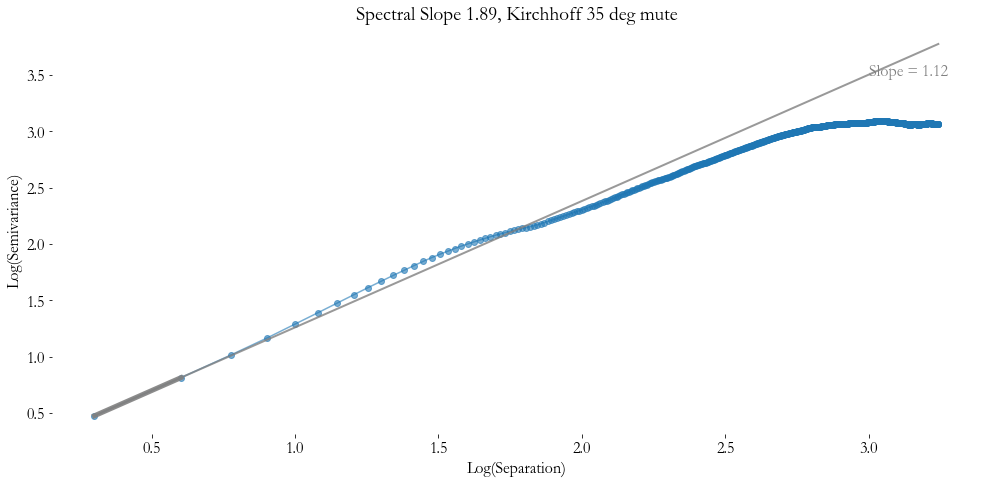

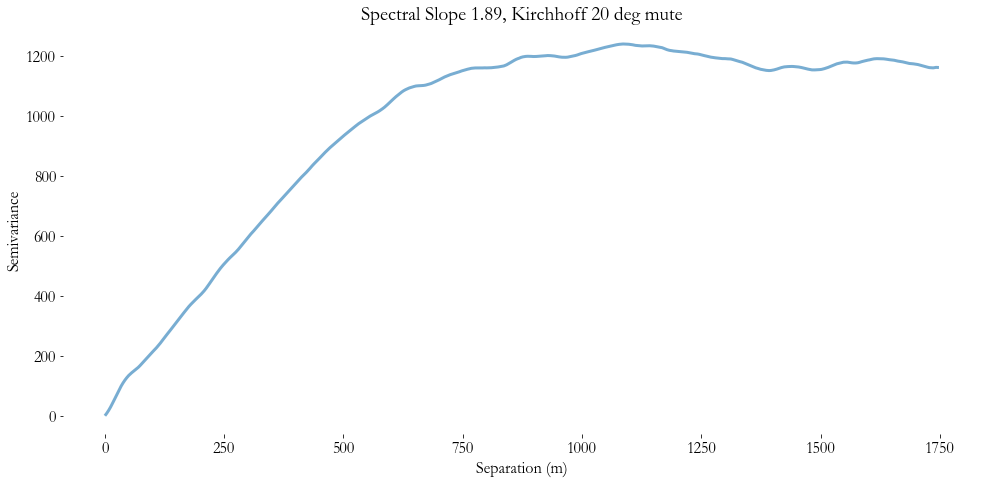

the length of the truncated semivariance is 875
For Spectral Slope 1.89, Kirchhoff 20 deg mute:

The slope is 1.04 and intercept it 0.31. The Hausdorff measure is 0.52, and the fractal dimension is 1.48.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


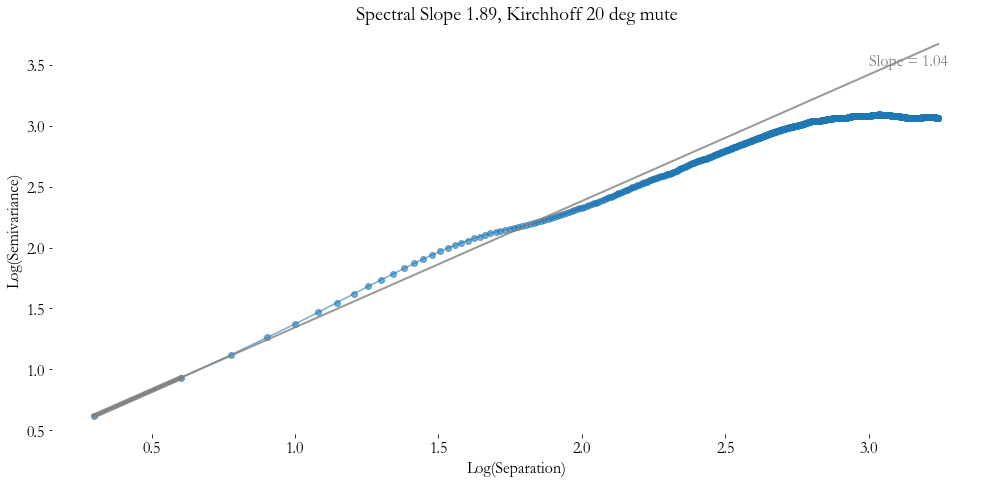

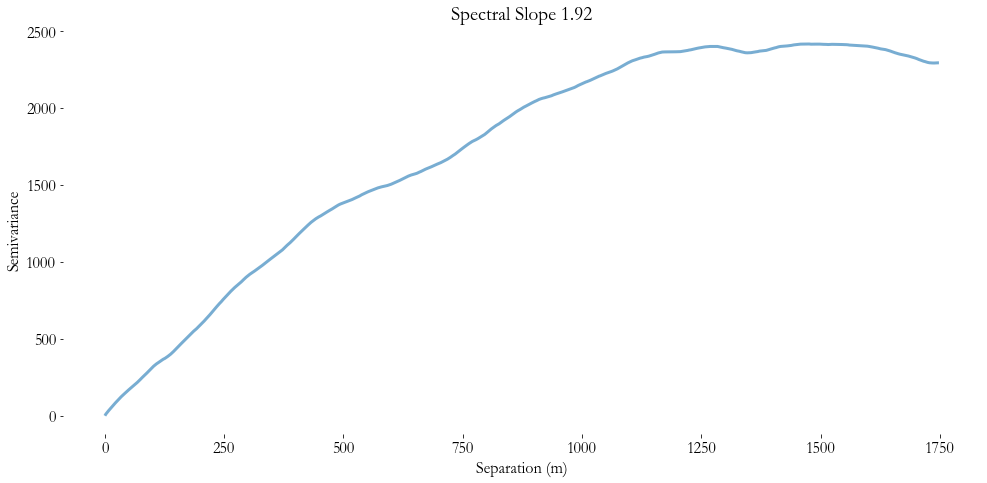

the length of the truncated semivariance is 875
For Spectral Slope 1.92:

The slope is 0.81 and intercept it 0.79. The Hausdorff measure is 0.41, and the fractal dimension is 1.59.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


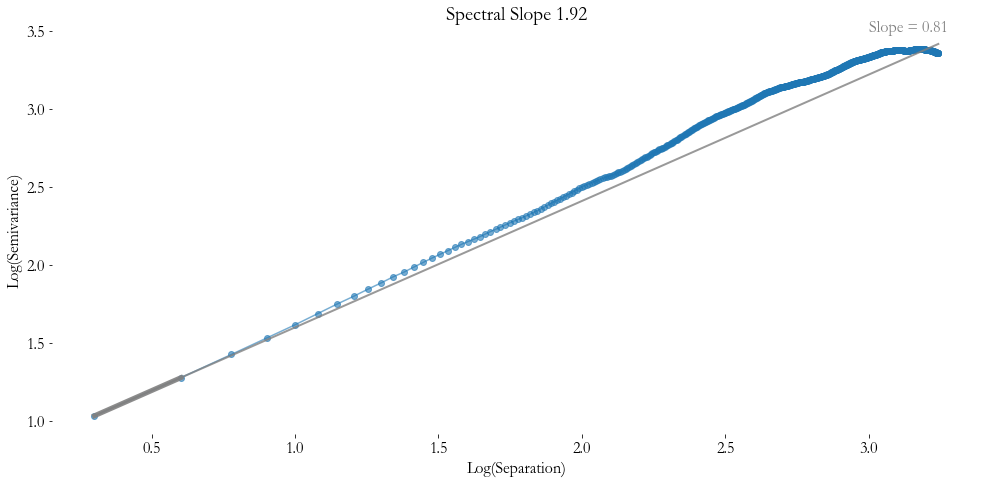

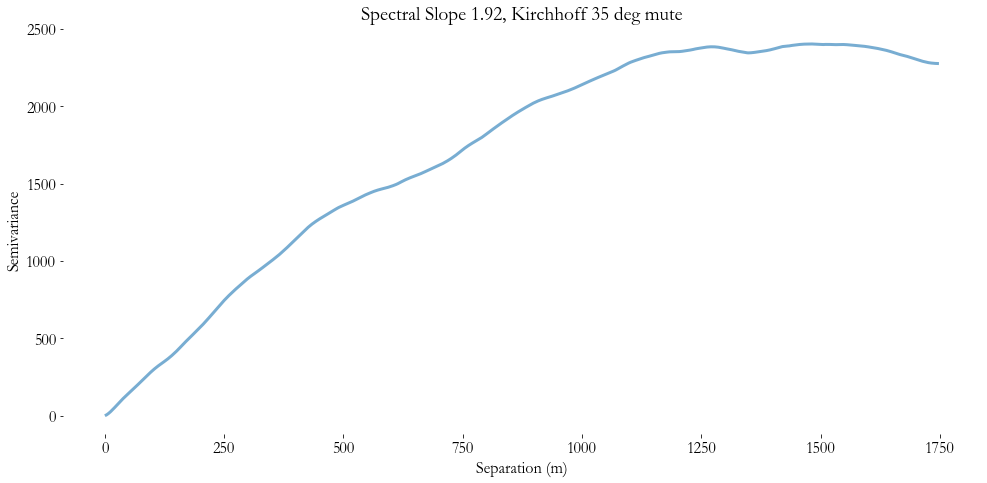

the length of the truncated semivariance is 875
For Spectral Slope 1.92, Kirchhoff 35 deg mute:

The slope is 1.07 and intercept it 0.19. The Hausdorff measure is 0.54, and the fractal dimension is 1.46.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


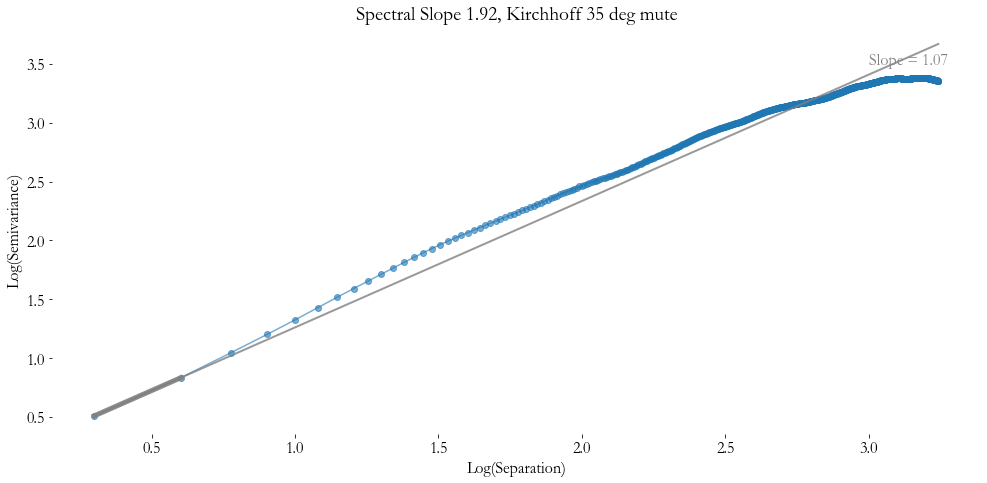

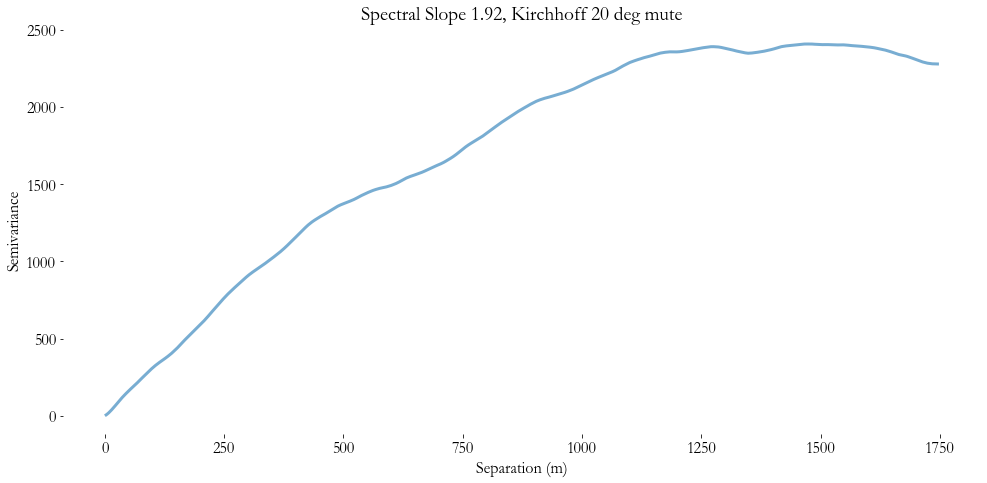

the length of the truncated semivariance is 875
For Spectral Slope 1.92, Kirchhoff 20 deg mute:

The slope is 1.05 and intercept it 0.3. The Hausdorff measure is 0.53, and the fractal dimension is 1.47.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


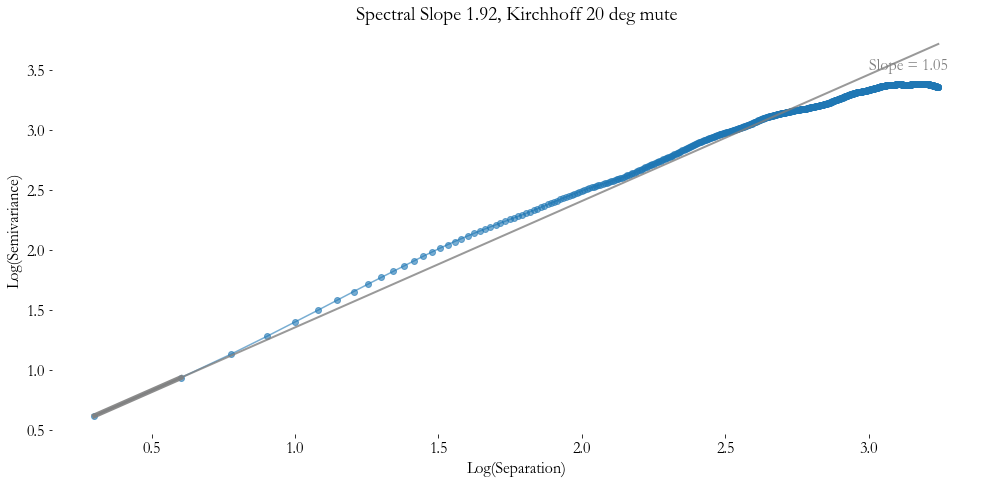

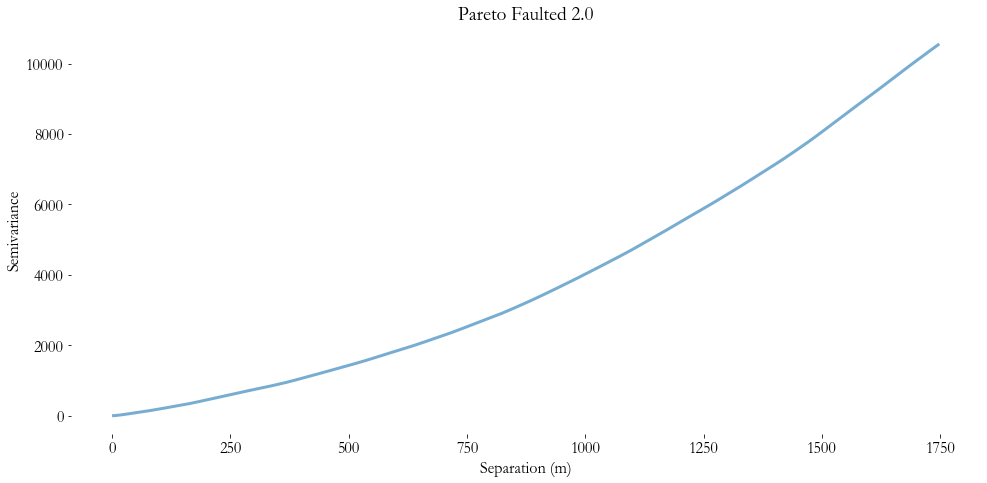

the length of the truncated semivariance is 875
For Pareto Faulted 2.0:

The slope is 1.56 and intercept it -0.5. The Hausdorff measure is 0.78, and the fractal dimension is 1.22.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


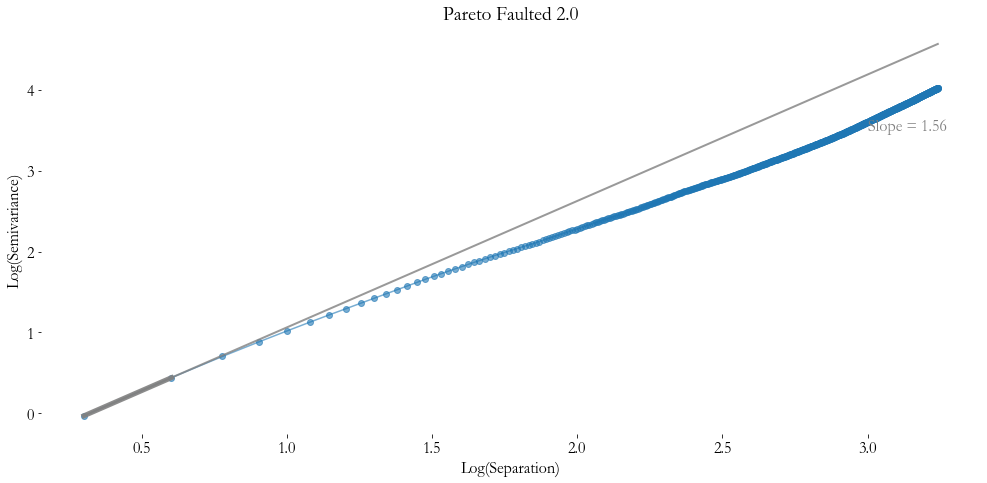

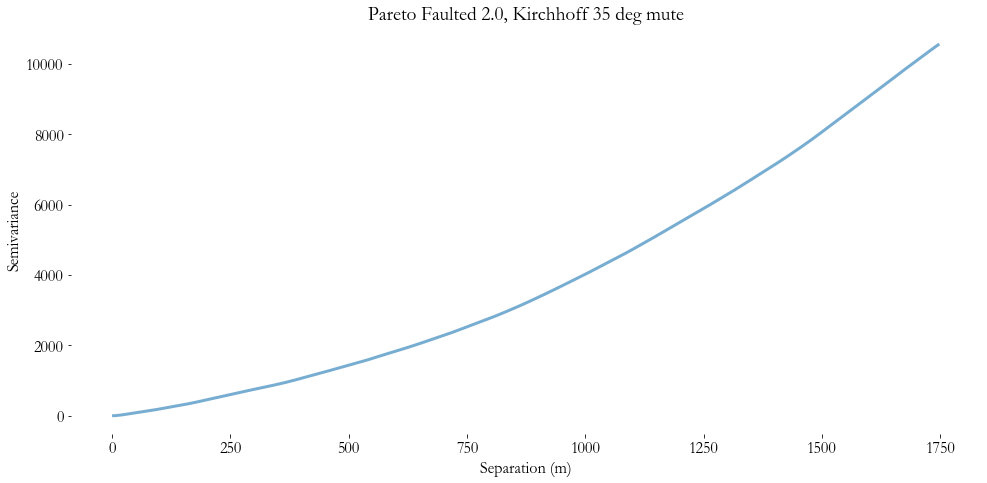

the length of the truncated semivariance is 875
For Pareto Faulted 2.0, Kirchhoff 35 deg mute:

The slope is 1.48 and intercept it -0.67. The Hausdorff measure is 0.74, and the fractal dimension is 1.26.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


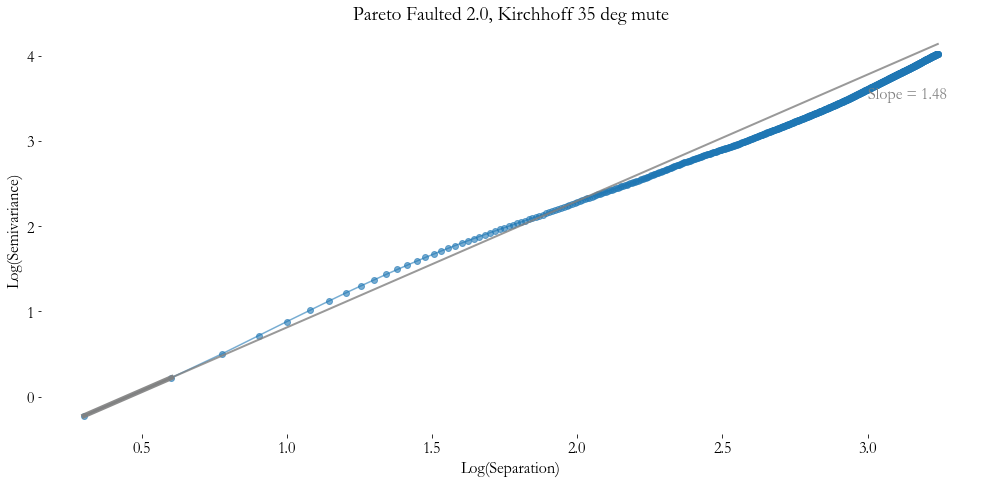

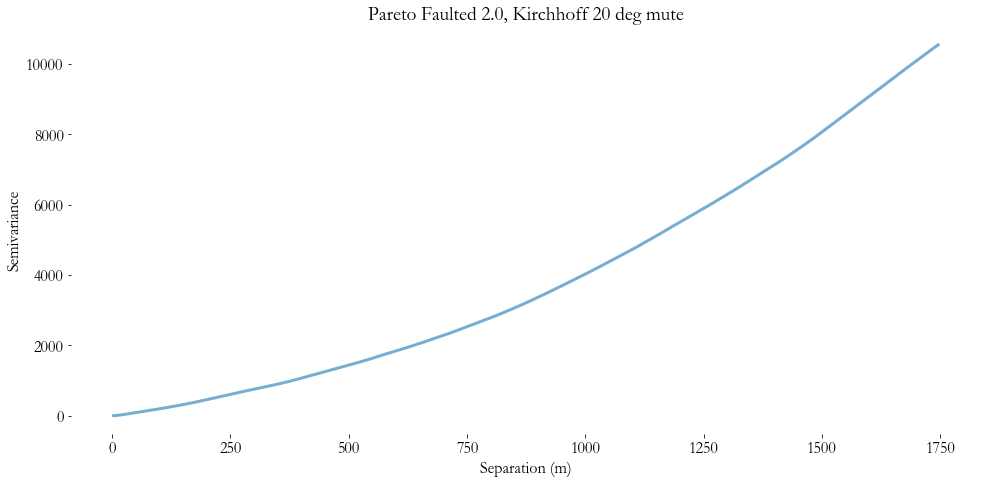

the length of the truncated semivariance is 875
For Pareto Faulted 2.0, Kirchhoff 20 deg mute:

The slope is 1.44 and intercept it -0.55. The Hausdorff measure is 0.72, and the fractal dimension is 1.28.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


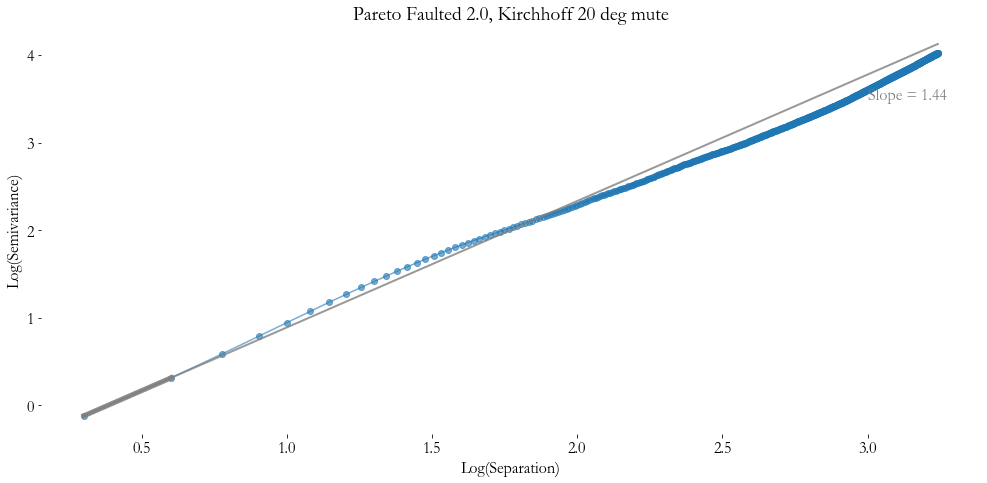

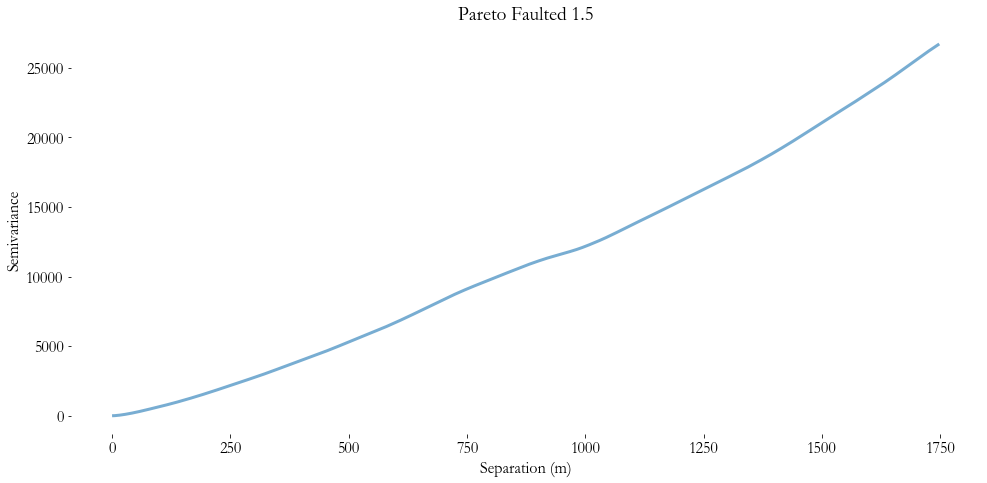

the length of the truncated semivariance is 875
For Pareto Faulted 1.5:

The slope is 1.73 and intercept it -0.4. The Hausdorff measure is 0.87, and the fractal dimension is 1.13.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


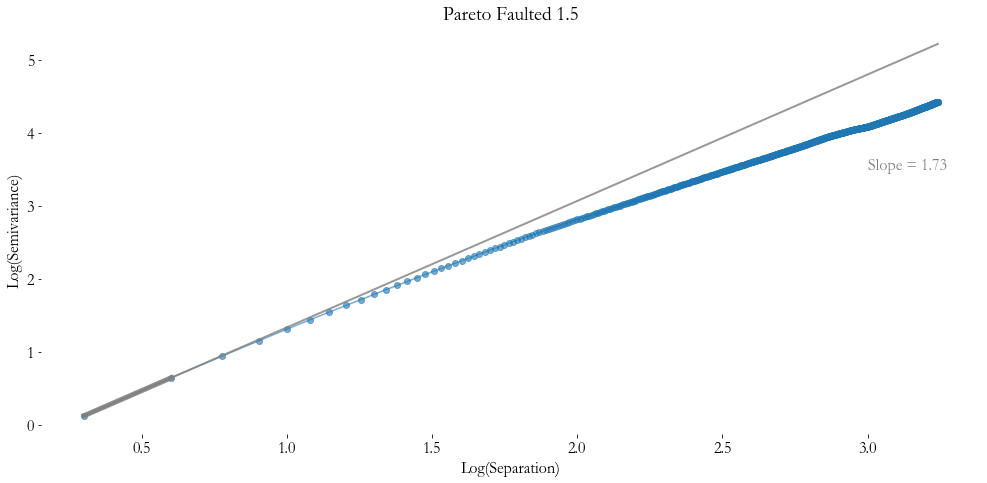

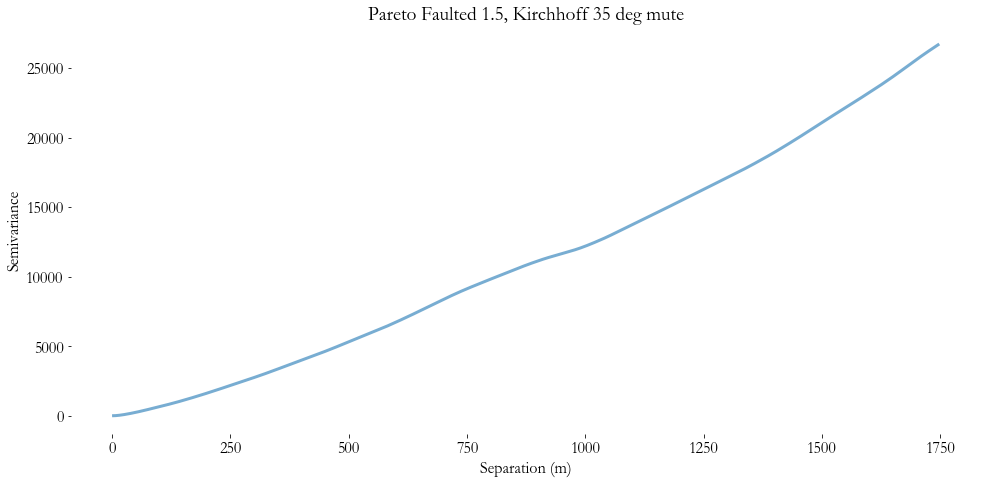

the length of the truncated semivariance is 875
For Pareto Faulted 1.5, Kirchhoff 35 deg mute:

The slope is 1.73 and intercept it -0.55. The Hausdorff measure is 0.86, and the fractal dimension is 1.14.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


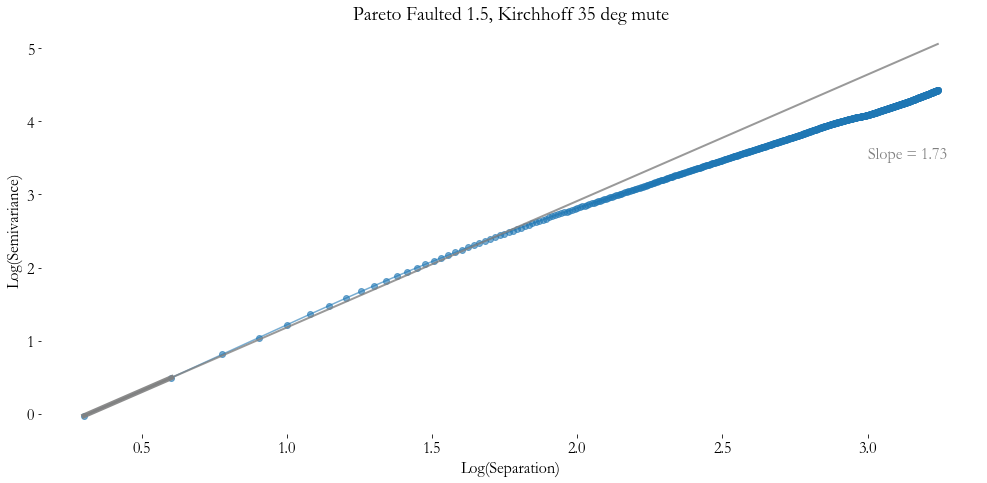

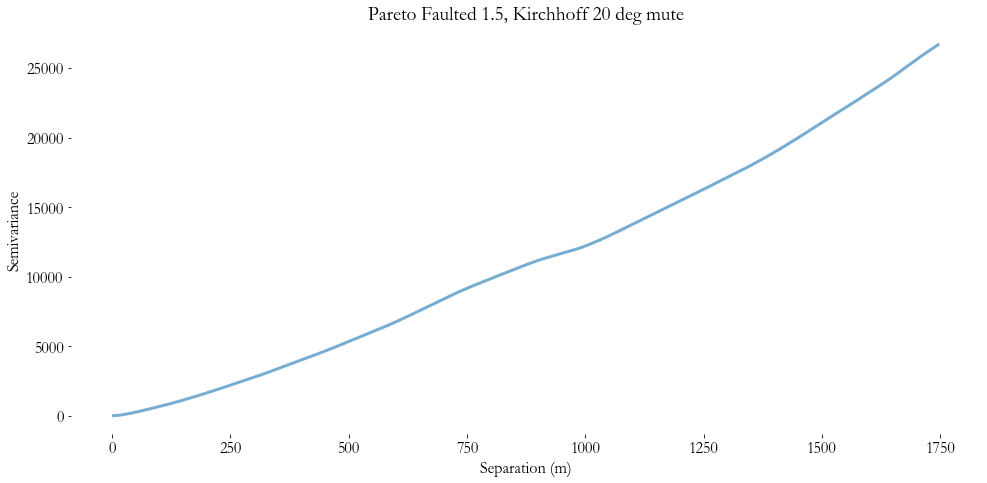

the length of the truncated semivariance is 875
For Pareto Faulted 1.5, Kirchhoff 20 deg mute:

The slope is 1.53 and intercept it -0.3. The Hausdorff measure is 0.77, and the fractal dimension is 1.23.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


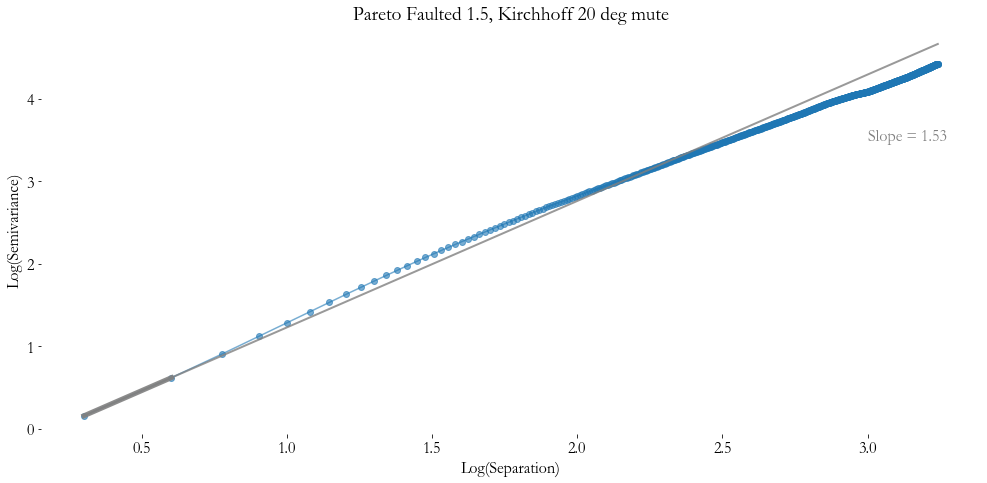

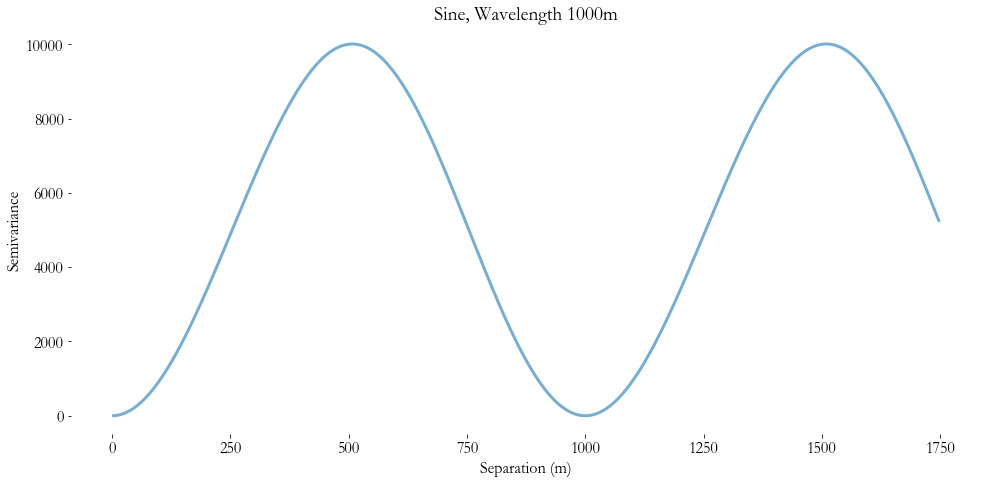

the length of the truncated semivariance is 875
For Sine, Wavelength 1000m:

The slope is 1.83 and intercept it -0.88. The Hausdorff measure is 0.91, and the fractal dimension is 1.09.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


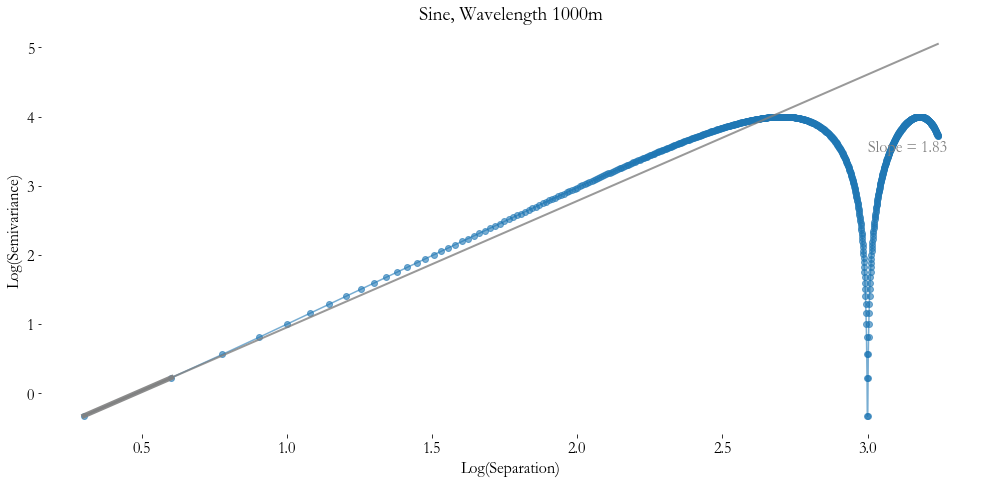

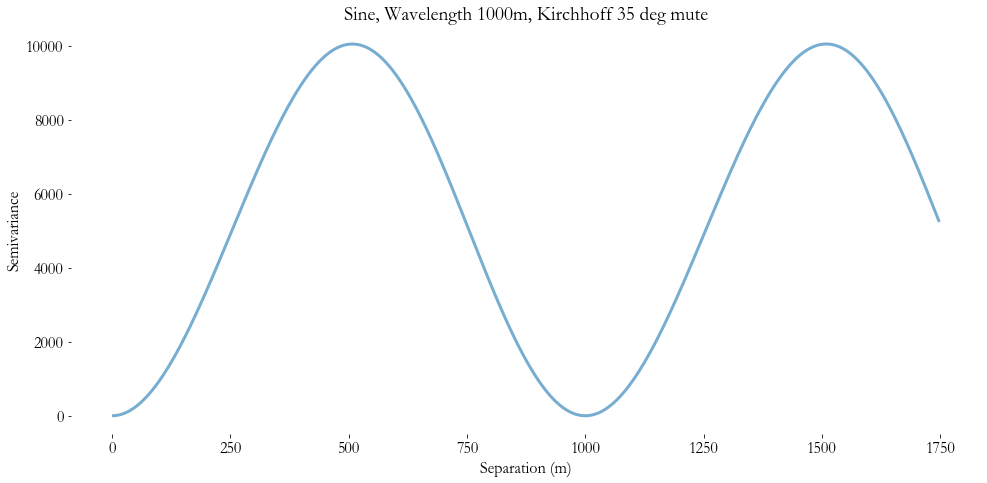

the length of the truncated semivariance is 875
For Sine, Wavelength 1000m, Kirchhoff 35 deg mute:

The slope is 1.78 and intercept it -0.84. The Hausdorff measure is 0.89, and the fractal dimension is 1.11.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


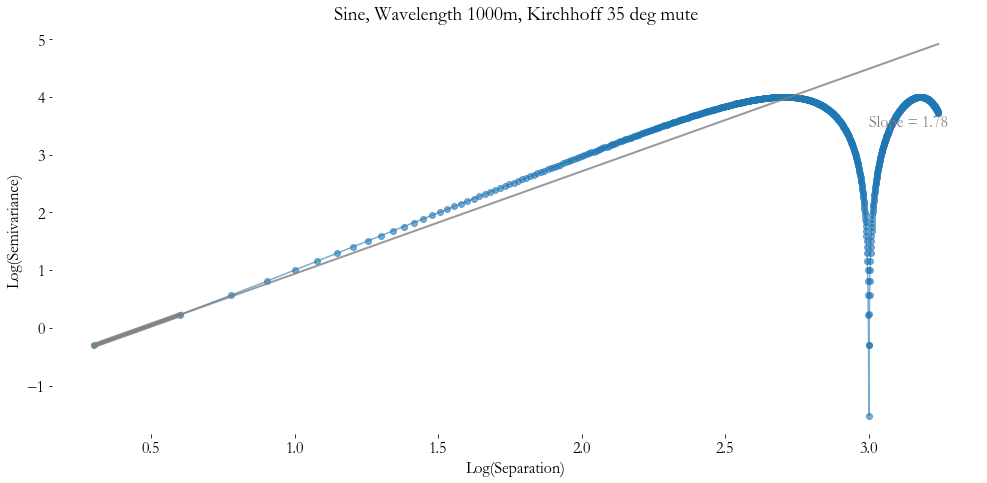

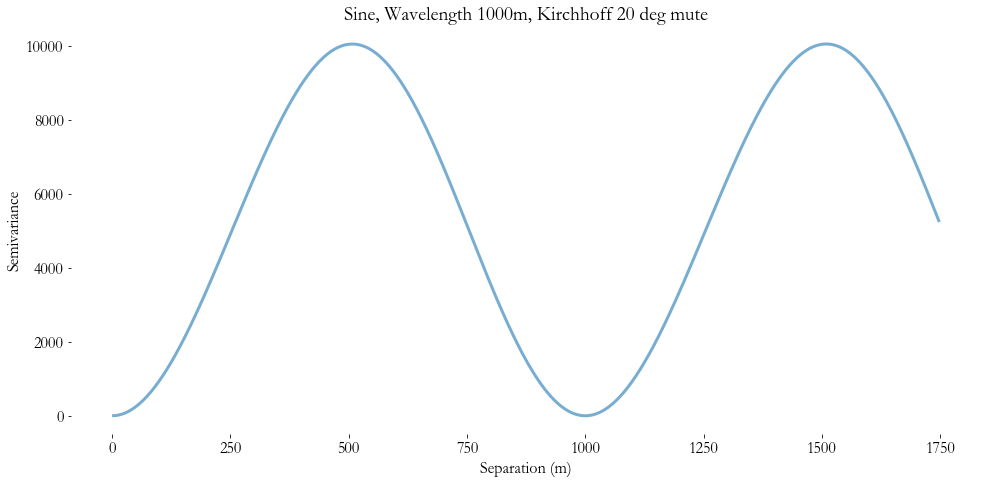

the length of the truncated semivariance is 875
For Sine, Wavelength 1000m, Kirchhoff 20 deg mute:

The slope is 1.77 and intercept it -0.84. The Hausdorff measure is 0.89, and the fractal dimension is 1.11.

################################################


C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


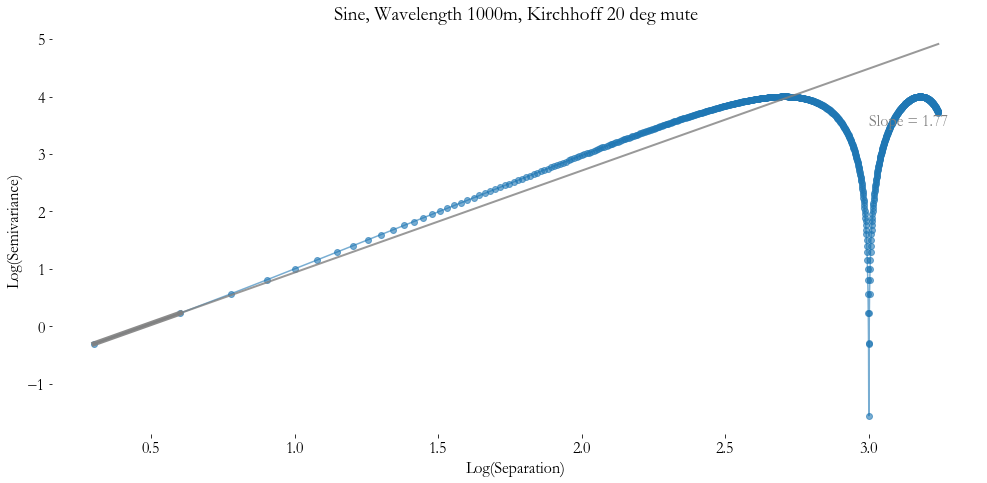

In [43]:
for i in range(len(data_list)):
    col=data_list[i][0]
    title=data_list[i][1]
    # Semivariogram work:
    combined_gamma_plot2(df_input, depth_col=col, title=title, step=2, s_der_strt=1, s_der_fin=3, file_out=True, location=location_out_plots)

In [44]:
with open(location_out+'semivariogram_summary.tsv', 'a') as the_file:
    the_file.write('Title\t Slope\t Intercept\t Fractal Dimension\n')
    
    for i in range(len(data_list)):
        col=data_list[i][0]
        title=data_list[i][1]

        samples = df_input[col].to_list()
        gamma = semivariance(samples)
        gamma_trunc = restrict_quarter(gamma)

        slope, intercept = gamma_log_slope_intercept(gamma_trunc, start=0, title=title, step=2, s_der_strt=1, s_der_fin=3)[0:2]

        res_slope = slope
        res_int = intercept
        haus = res_slope/2
        frac_dim = 2 - haus

        res_slope = round(res_slope, 2)
        res_int = round(res_int, 2)
        haus = round(haus, 2)
        frac_dim =round(frac_dim, 2)
    
        the_file.write(f'{title}\t {res_slope}\t {res_int}\t {frac_dim}\n')
    

For Spectral Slope 1.89:

The slope is 0.83 and intercept it 0.77. The Hausdorff measure is 0.41, and the fractal dimension is 1.59.

################################################
For Spectral Slope 1.89, Kirchhoff 35 deg mute:

The slope is 1.12 and intercept it 0.14. The Hausdorff measure is 0.56, and the fractal dimension is 1.44.

################################################
For Spectral Slope 1.89, Kirchhoff 20 deg mute:

The slope is 1.04 and intercept it 0.31. The Hausdorff measure is 0.52, and the fractal dimension is 1.48.

################################################
For Spectral Slope 1.92:

The slope is 0.81 and intercept it 0.79. The Hausdorff measure is 0.41, and the fractal dimension is 1.59.

################################################
For Spectral Slope 1.92, Kirchhoff 35 deg mute:

The slope is 1.07 and intercept it 0.19. The Hausdorff measure is 0.54, and the fractal dimension is 1.46.

################################################
For Spectral Slo

## Combined Log-Log Plots 

### Sine Model

In [45]:
title='Sine Wave, Semivariograms'
labels = ['Sine, Wavelength 1000m', 'Sine, Wavelength 1000m, Kirchhoff 35 deg mute', 'Sine, Wavelength 1000m, Kirchhoff 20 deg mute']
columns = ['sin1000', 'sin1000SPIRIT:T0_35,1', 'sin1000SPIRIT:T0_20,1']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = semivariance(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)


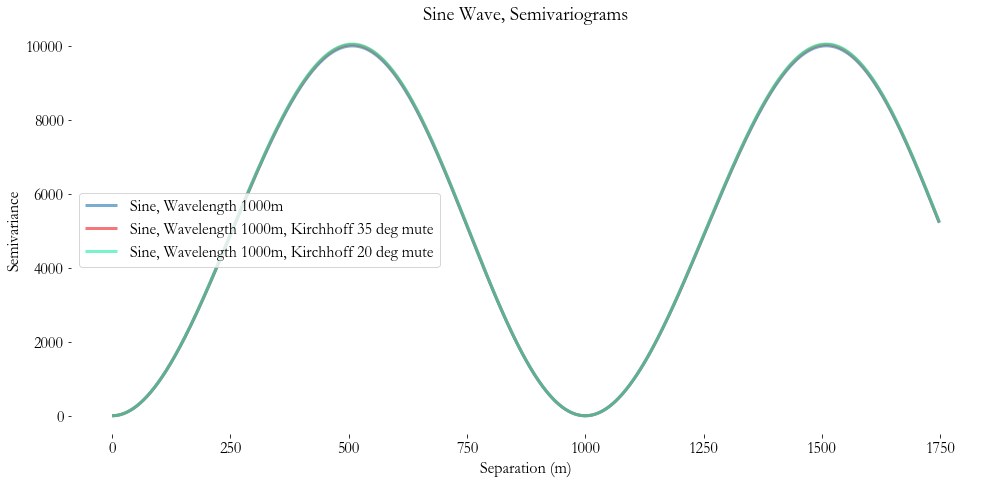

In [46]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

C:\Users\mu62945\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


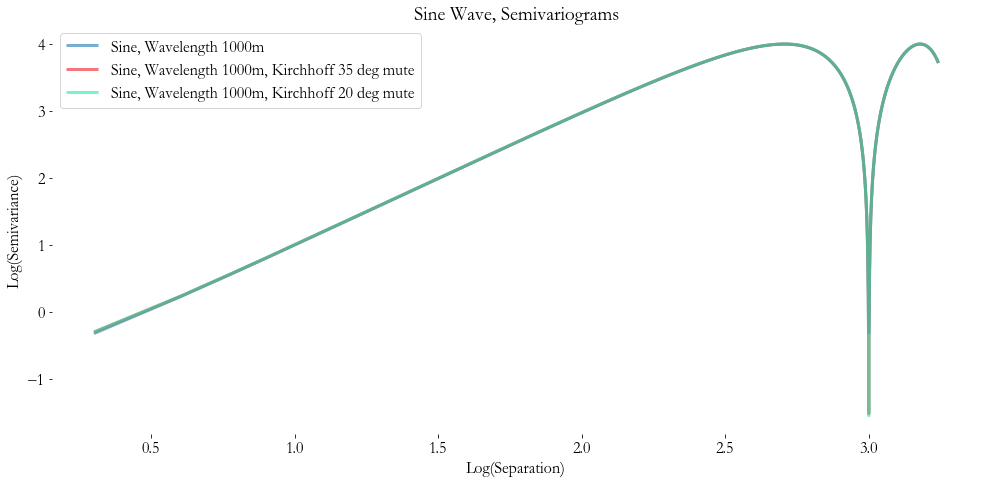

In [47]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

### Pareto Fault Models

In [48]:
title='Pareto Faulted 2.0, Semivariograms'
labels = ['Pareto Faulted 2.0', 'Pareto Faulted 2.0, Kirchhoff 35 deg mute', 'Pareto Faulted 2.0, Kirchhoff 20 deg mute']
columns = ['Pareto_fault_interface_b_2p0', 'Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_35', 'Pareto_fault_interface_b_2p0_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = semivariance(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

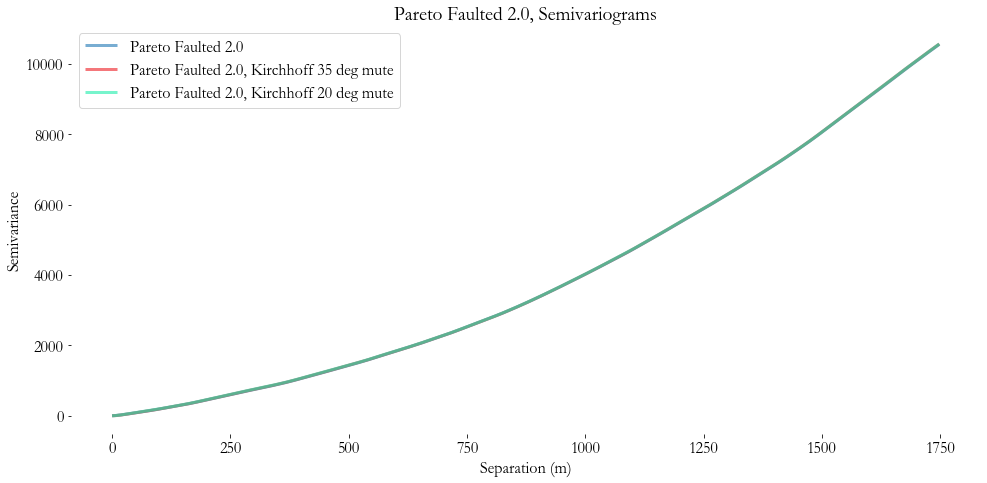

In [49]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

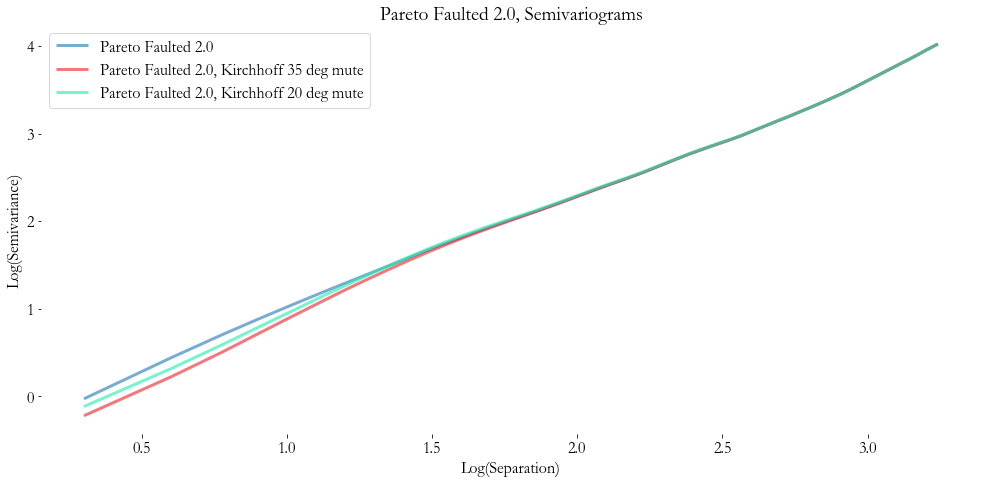

In [50]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

In [51]:
title='Pareto Faulted 1.5, Semivariograms'
labels = ['Pareto Faulted 1.5', 'Pareto Faulted 1.5, Kirchhoff 35 deg mute', 'Pareto Faulted 1.5, Kirchhoff 20 deg mute']
columns = ['Pareto_fault_interface_b_1p5', 'Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_35', 'Pareto_fault_interface_b_1p5_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = semivariance(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

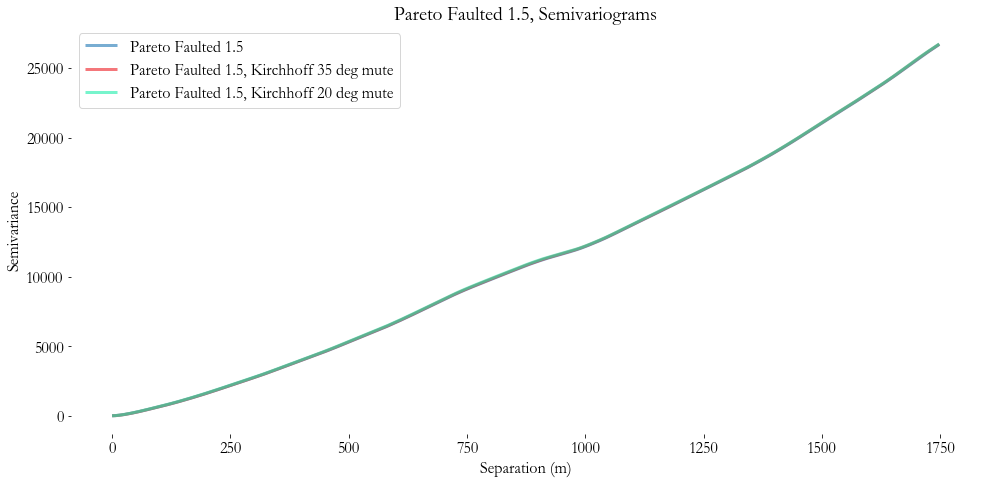

In [52]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

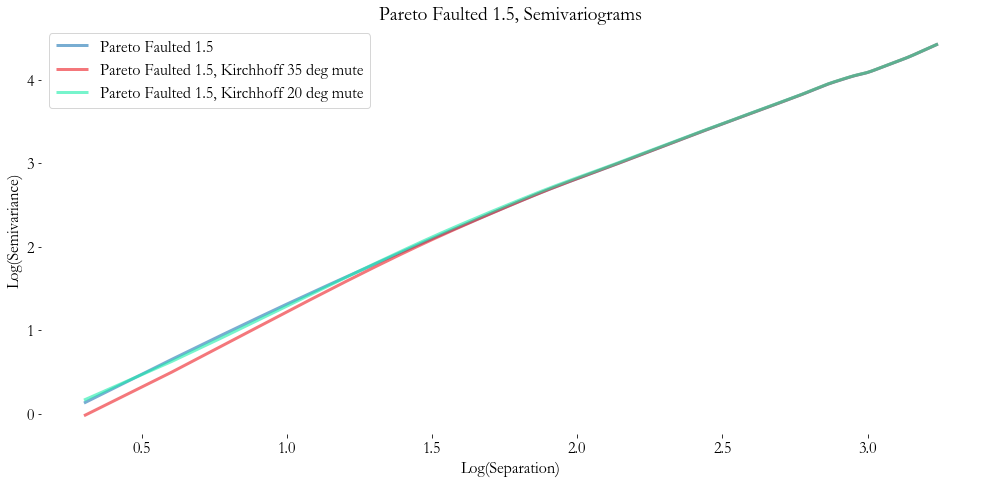

In [53]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

### Spectral Slope Models

In [54]:
title='Spectral Slope 1.89, Semivariograms'
labels = ['Spectral Slope 1.89', 'Spectral Slope 1.89, Kirchhoff 35 deg mute', 'Spectral Slope 1.89, Kirchhoff 20 deg mute']
columns = ['Spectral_slope_interface_1p89', 'Spectral_slope_interface_1p89_CFST7SPIRIT:T0_35', 'Spectral_slope_interface_1p89_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = semivariance(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

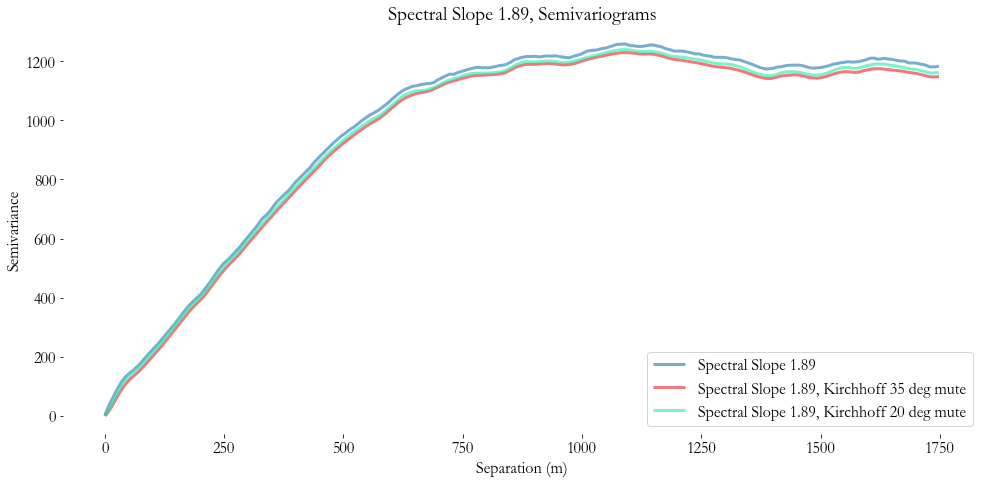

In [55]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

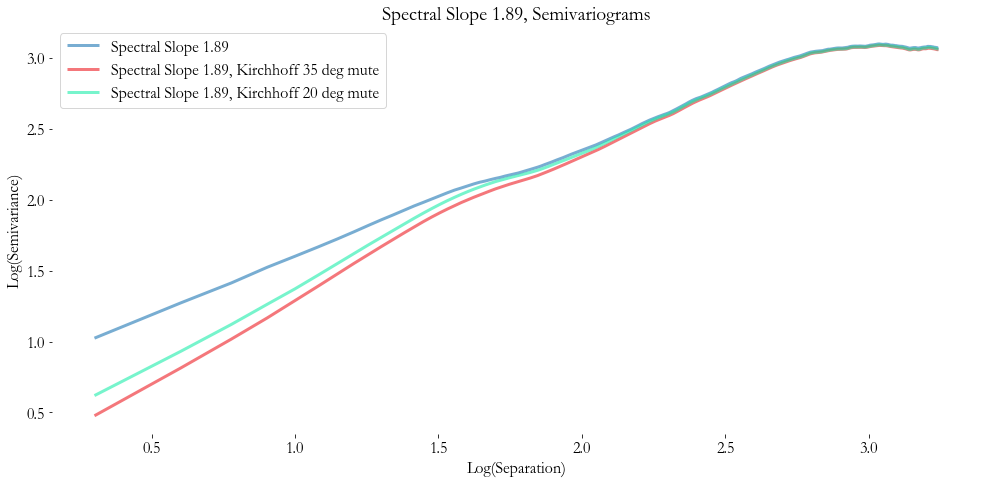

In [56]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

In [57]:
title='Spectral Slope 1.92, Semivariograms'
labels = ['Spectral Slope 1.92', 'Spectral Slope 1.92, Kirchhoff 35 deg mute', 'Spectral Slope 1.92, Kirchhoff 20 deg mute']
columns = ['Spectral_slope_interface_1p92', 'Spectral_slope_interface_1p92_CFST7SPIRIT:T0_35', 'Spectral_slope_interface_1p92_CFST7SPIRIT:T0_20']
gammas = []
for i in range(len(columns)):
    col=columns[i]
   
    samples = df_input[col].to_list()
    gamma = semivariance(samples)
    gamma_trunc = restrict_quarter(gamma)
    gammas.append(gamma_trunc)

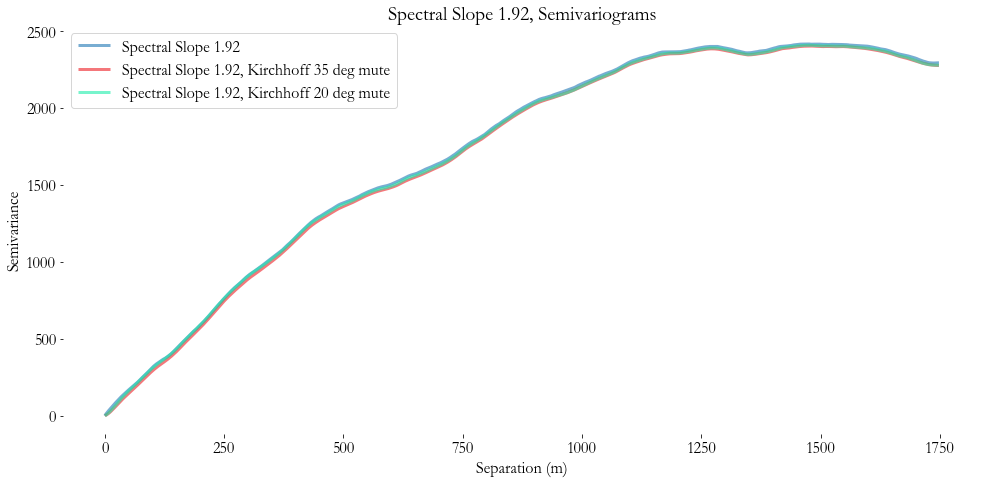

In [58]:
gamma_list_plot(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)

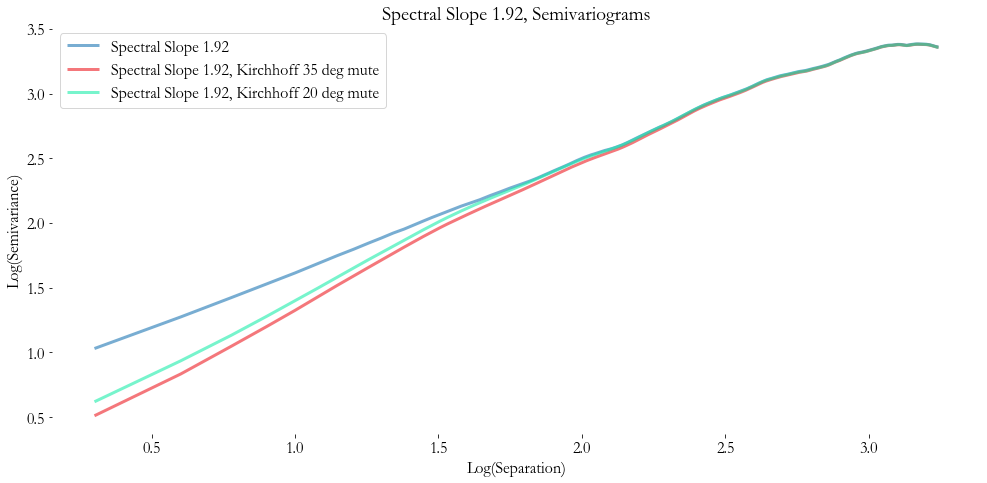

In [59]:
gamma_list_plot_log(gammas, labels, start=0, title=title, step=2, file_out=True, location=location_out_plots)